In [35]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import eos_integrate
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", dpi=144)
import scipy.optimize
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring $\alpha$-$\beta$ space

We have a pulsar of known mass (${\sim}1.43 M_\odot$) and for each $\alpha_0$, $\beta_0$ we want to compute $\alpha_A$ and determine whether $\alpha_0(\alpha_A-\alpha_0)<\Delta_{max}$. But when we integrate an EOS we supply the central pressure, scalar value, and $\beta_0$, and we get out $\alpha_0$, $m_A$, and $\alpha_A$. So we have some root-finding to do. 
* Option 1: Use 2D root-finding to compute the right $\alpha_0$ for each $\beta_0$.
* Option 2: Build a database of pulsars on a grid of pressure, scalar value, and $\beta_0$. Then use interpolation to draw limit curves.
* Option 3: Use 1D root finding on the mass, then explore phi_0 values

Note that we have to do this for several different pulsar masses and constraint levels; at least 0348, 1738, and 0337. So Option 2 has some appeal. Particularly as we're not yet quite sure what our limit will be.

In [11]:
def f(x, beta_0):
    lp_c, lphi_c = x
    p_c = np.exp(lp_c)
    phi_c = np.exp(lphi_c)
    print(p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    res = np.array([m_A-1.43, alpha_0*(alpha_A-alpha_0)-1.6e-6])
    print(res)
    return res

r = scipy.optimize.root(
    f, 
    [np.log(0.76e15), np.log(1e-3)],
    args=(-3,),
    method="lm")

7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6000038804e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.00100000010293 -3
[ -1.42930227e+00  -1.60000028e-06]
inf 0.0 -3
[ nan  nan]
inf 0.0 -3
[ nan  nan]
4.49165968976e+74 0.0 -3


/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
eos_integrate.py:239: RuntimeWarning: invalid value encountered in double_scalars
  * a_phi*(e-3*p_c))
eos_integrate.py:212: RuntimeWarning: invalid value encountered in double_scalars
  * (a_phi*(e-3*p)+rho*psi*(e-p))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Illegal input detected. (See printed message.)
  'Unexpected istate=%s' % istate))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  'Unexpected istate=%s' % istate))


FloatingPointError: invalid value encountered in double_scalars

In [12]:
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

r = scipy.optimize.brentq(
    f, 
    0.1e15,1.7e15,
    args=(1e-3,-3))

In [13]:
r

553380971245249.5

In [14]:
solutions = set()

In [15]:
last = None
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

def g(phi_c, beta_0):
    rho_c = scipy.optimize.brentq(
        f, 
        0.1e15,1.7e15,
        args=(phi_c,beta_0))
    d = eos_integrate.evaluate(rho_c, phi_c, beta_0)
    global last
    last = (rho_c, phi_c, beta_0)
    print(last, d["Delta"])
    return np.abs(d["Delta"]) - 4e-7

xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),100))
ys = []
for phi_c in xs:
    ys.append(g(phi_c,-3))

#phi_c = scipy.optimize.brentq(
#    g, 
#    0.1e-3,0.5,
#    args=(-3,))

#d = eos_integrate.evaluate(*last)
#d

(553380970384513.25, 0.0010000000000000002, -3) -1.49283042036e-12
(553381024003905.06, 0.00106478597782335, -3) -1.6925311849e-12
(553381132400044.5, 0.0011337691785692262, -3) -1.91894745989e-12
(553381255461851.9, 0.0012072215234288095, -3) -2.17565343154e-12
(553381401265732.1, 0.0012854325502735374, -3) -2.46670157307e-12
(553381552752109.06, 0.0013687105549689707, -3) -2.79668666877e-12
(553381744768206.06, 0.0014573838066297739, -3) -3.17081815576e-12
(553381906626758.25, 0.0015518018416061992, -3) -3.59500332264e-12
(553382096516413.8, 0.0016523368413027301, -3) -4.0759390689e-12
(553382291011554.06, 0.0017593850992600724, -3) -4.6212192725e-12
(553382538333004.5, 0.0018733685832834674, -3) -5.23945385435e-12
(553382817666282.56, 0.0019947365987750282, -3) -5.94040570902e-12
(553383135684612.9, 0.0021239675598266911, -3) -6.7351448443e-12
(553383496106532.1, 0.0022615708750551352, -3) -7.63622264989e-12
(553383943815952.75, 0.0024080889556123909, -3) -8.65787166978e-12
(5533843

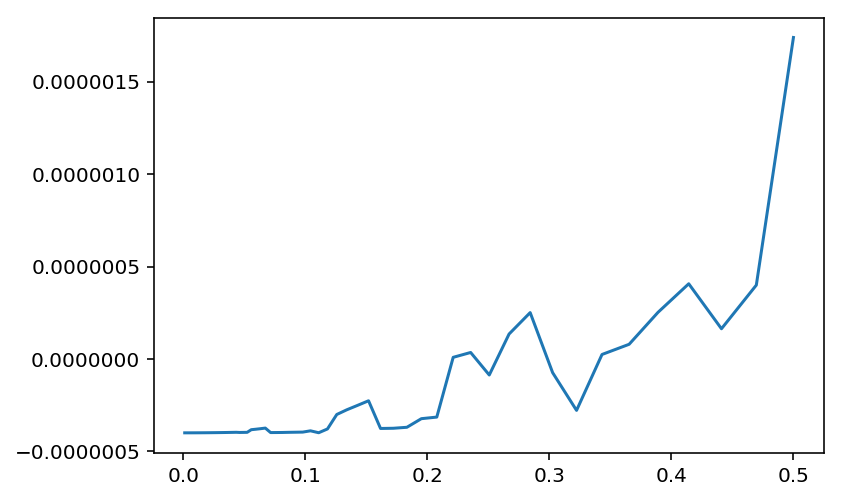

In [16]:
plt.plot(xs, ys)

In [17]:
l = []

In [18]:
l.insert?

In [19]:
points = []

In [20]:
eos_integrate.mr_curve(points, 0, 0, 1.43)

{'Delta': 0.0,
 'I_A': 2.2530921759394333e+36,
 'J_A': 2.2530921806348049e+36,
 'Omega': 1.0000000020839679,
 'Q1': 1.0,
 'Q2': 0.83131792872211197,
 'R': 13.652707150389318,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (6.204500705854884e+34, 0, 0),
 'm_A': 1.4299999999090507,
 'mb_A': 1.5663402707884728,
 'nu_hat': -0.369485943174853,
 'nu_prime': 3.2740070019246783e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [21]:
len(points)

103

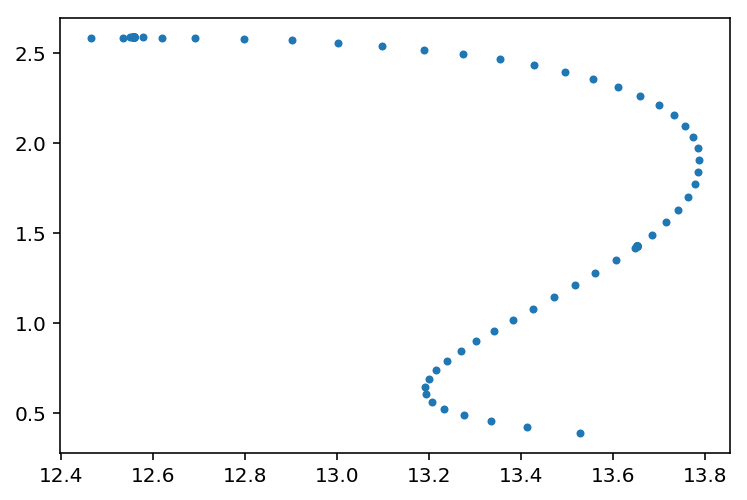

In [22]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")

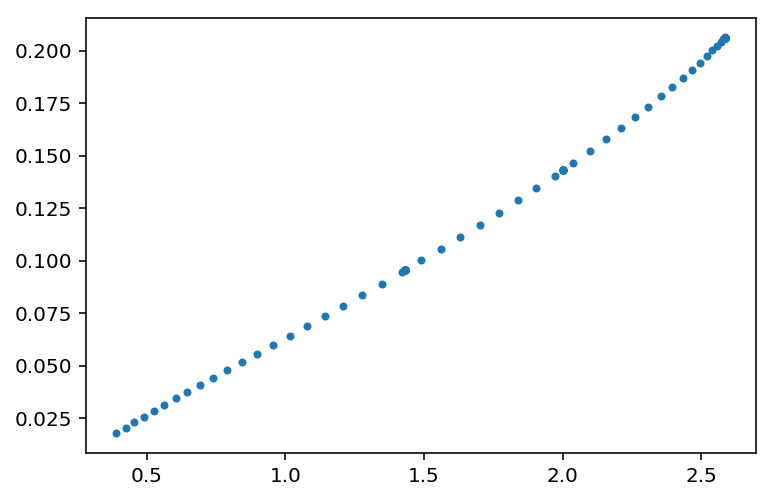

In [94]:
plt.plot([d["m_A"] for p_c,d in points],
         [(d["mb_A"]/d["m_A"]-1) for p_c,d in points],
         ".")

In [95]:
points[-1]

(8.017953205361365e+35,
 {'Delta': 0.0,
  'I_A': -9.5839040220688806e+36,
  'J_A': -9.5839043247691083e+36,
  'Omega': 1.0000000315842299,
  'Q1': 1.0,
  'Q2': 0.62307645388839084,
  'R': 12.465013098301814,
  'a': 0,
  'alpha_0': 0.0,
  'alpha_A': 0.0,
  'b': 0,
  'beta_0': 0,
  'initial': (8.017953205361365e+35, 0, 0),
  'm_A': 2.5856490353281099,
  'mb_A': 3.118482643725375,
  'nu_hat': -0.94617209760411847,
  'nu_prime': 1.2642030317421362e-06,
  'phi_0': 0.0,
  'rho_start': 1e-06})

In [23]:
eos_integrate.mr_curve(points, 0, 0, 2.0)

{'Delta': 0.0,
 'I_A': -4.846746127815239e+38,
 'J_A': -4.8467456783196633e+38,
 'Omega': 0.99999990725827925,
 'Q1': 1.0,
 'Q2': 0.75627353053489899,
 'R': 13.780042337385396,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (1.3668680456297637e+35, 0, 0),
 'm_A': 2.0000000001226454,
 'mb_A': 2.2859172117225328,
 'nu_hat': -0.55870431072849713,
 'nu_prime': 5.4310837607406777e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [24]:
len(points)

114

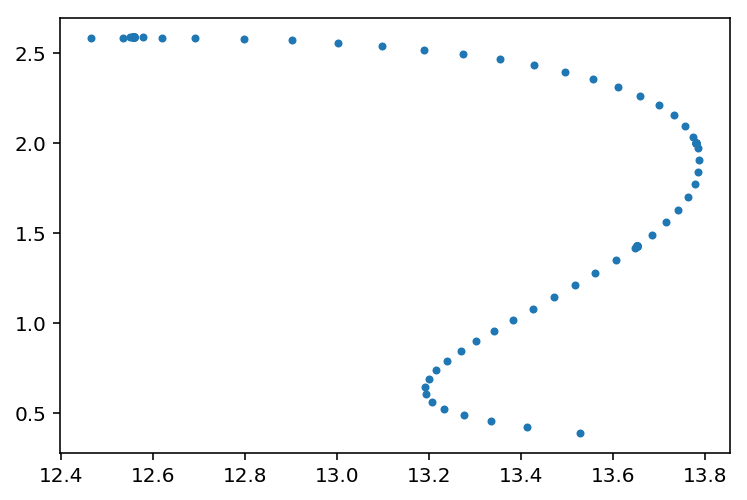

In [25]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")

In [26]:
alpha_map = {}

In [27]:
xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),10))
ys = []
for phi_c in xs:
    if phi_c not in alpha_map:
        alpha_map[phi_c] = []
    try:
        d = eos_integrate.mr_curve(alpha_map[phi_c], phi_c, -3, 1.43)
        ys.append(d)
        print(phi_c, d["Delta"])
    except FloatingPointError:
        pass

0.001 8.24350498994e-07
0.00199473659878 3.28005144709e-06
0.00397897409849 1.3050962925e-05
0.00793700525984 5.19249061264e-05
0.0158322348765 0.000206537718607
0.0315811383485 0.000820700947017
0.0629960524947 0.00324746140498
0.12566053149 0.0126042330155
0.250659661184 0.0434963224749
0.5 0.0240830007927


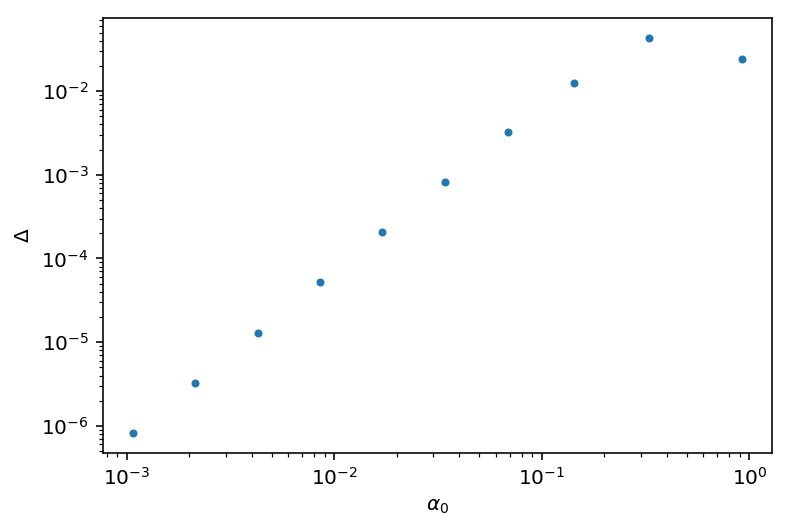

In [28]:
plt.loglog([abs(y["alpha_0"]) for y in ys], 
           [y["Delta"] for y in ys], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\Delta$")

In [29]:
eos_integrate.explore_alpha(alpha_map, -3, 1.43, 
                            lambda d: abs(d["Delta"])-4e-7)

1e-06 -1.0730906788e-06
1 -2.72956824633
No spontaneous scalarization found
0 0 condition: -4e-07
1 1 condition: 1.02242521044
0 0 condition: -4e-07
1 1 condition: 1.02242521044
0.0158322348765 0.0158322348765 condition: 0.000206137718607
0.00199473659878 0.00199473659878 condition: 2.88005144709e-06
1e-06 1e-06 condition: -3.99999175648e-07
0.001 0.001 condition: 4.24350498994e-07
1e-06 1e-06 condition: -3.99999175648e-07
0.001 0.001 condition: 4.24350498994e-07
brentq with 1e-06 -3.99999175648e-07 0.001 4.24350498994e-07 xtol 1e-12
1e-06 1e-06 condition: -3.99999175648e-07
0.001 0.001 condition: 4.24350498994e-07
0.000485744749424 0.000485744749424 condition: -2.05495875543e-07
0.000830792604753 0.000830792604753 condition: 1.68980569809e-07
0.000675091534824 0.000675091534824 condition: -2.43029975253e-08
0.000694669002114 0.000694669002114 condition: -2.19686774692e-09
0.000696589606666 0.000696589606666 condition: 5.85812797886e-12
0.000696584498837 0.000696584498837 condition: -2

{'Delta': 4.0000000403812537e-07,
 'I_A': 2.2693109224647536e+36,
 'J_A': 2.2693109272151741e+36,
 'Omega': 1.0000000020933317,
 'Q1': 1.0000008225527912,
 'Q2': 0.8313180224496084,
 'R': 13.652711969058156,
 'a': 0,
 'alpha_0': -0.0007474996305027263,
 'alpha_A': -0.0012826169572753266,
 'b': -3,
 'beta_0': -3,
 'initial': (6.204514622350647e+34, 0.0006965845092975686, -3),
 'm_A': 1.4300000005398987,
 'mb_A': 1.5663431828409173,
 'nu_hat': -0.36948578143515487,
 'nu_prime': 3.274004058376633e-07,
 'phi_0': 0.00024916654350090877,
 'rho_start': 1e-06}

In [30]:
all_map = {}


In [31]:
betas = np.linspace(-6,6,40)
eos_integrate.explore_beta(all_map, betas, mass_0337, 
                           condition_0337)

NameError: name 'mass_0337' is not defined

In [ ]:
betas = sorted(all_map.keys())
ds = [eos_integrate.explore_alpha(all_map[beta], beta, mass_0337,
                                      condition_0337)
          for beta in betas]
alphas = np.array([d["alpha_0"] for d in ds])


In [ ]:
plt.plot(betas, np.log10(np.abs(alphas)), ".-")
plt.xlabel(r"$|\beta_0|$")
plt.ylabel(r"$\log_{10}|\alpha_0|$")
plt.ylim(-4,-1)
#cassini_limit = 3.4e-3
cassini_limit = 3.4e-3

plt.axhline(np.log10(cassini_limit))

plt.savefig("alpha-beta-0337-ska.pdf")

In [91]:
w = 15000
(1+w)/(2+w)-1

-6.665777896275316e-05

## Checking the calculation of $\alpha_0$

In [ ]:
mass = 1.43
phi_c = 0.001
beta = -1
points = []

d = eos_integrate.mr_curve(points, phi_c, beta, mass) 

In [ ]:
d["alpha_0"], d["phi_0"], d["alpha_A"]

In [ ]:
N = eos_integrate.NeutronStar(a = d["alpha_0"], b = d["beta_0"])
N.integrate(d["initial"][0], d["initial"][1]-d["phi_0"])
N.alpha_0, N.phi_0, N.alpha_A

In [ ]:
N.Delta

## LLR constraint

Lunar laser ranging provides a constraint on $\alpha_0$ and $\beta_0$. It comes in the weak-field regime, where we are at 1PN order even inside the bodies. We can therefore write it in terms of the Eddington parameters:
$$
\bar \gamma \equiv \gamma_{Edd} - 1 = -2\alpha_0^2/(1+\alpha_0^2)
$$
and
$$
\bar \beta \equiv \beta_{Edd} - 1 = \frac{1}{2}\beta_0\alpha_0^2/(1+\alpha_0^2)^2.
$$
The LLR constraint is 
$$
|\eta_N| < 10^{-3}
$$
and we have, in these Lorentz-invariant theories,
$$
\eta_N = 4\beta_{Edd}-\gamma_{Edd}-3.
$$
Rewriting, we get
$$
\left| 2\beta_0\alpha_0^2/(1+\alpha_0^2)^2 + 2\alpha_0^2/(1+\alpha_0^2) \right| < 10^{-3}
$$
or
$$
\left| \frac{2\alpha_0^2}{(1+\alpha_0^2)^2}(\beta_0+1+\alpha_0^2) \right| < 10^{-3}
$$

Current best LLR constraint is $(-0.2\pm1.1)\times 10^{-4}$ from hm18; the corresponding two-sigma upper limit is $2.4\times 10^{-4}$. Also $\Delta = (-3.0\pm5.0)\times 10^{-14}$ and $U_EM$ is $-4.45\times 10^{-10}$.

In [40]:
llr_eta = 2.4e-4

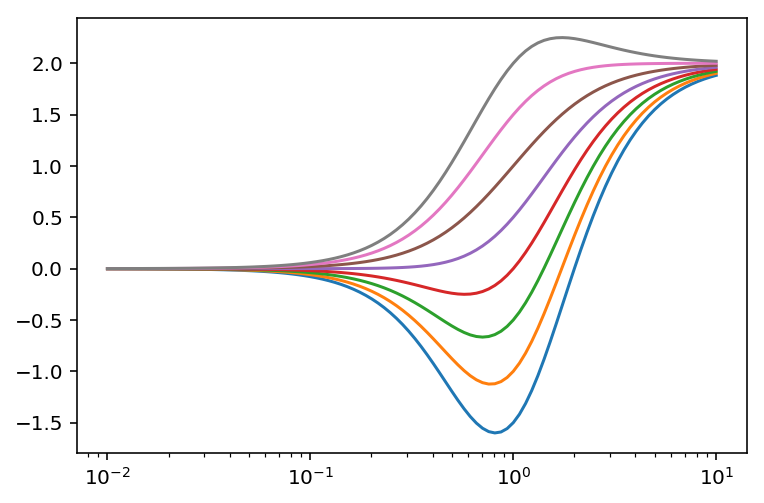

In [41]:
def llrrhs(asq, beta_0):
    return 2*asq*(beta_0+1+asq)/(1+asq)**2

alphas = np.exp(np.linspace(np.log(1e-2),np.log(10),100))
for beta_0 in [-5,-4,-3,-2,-1,0,1,2]:
    plt.semilogx(alphas, llrrhs(alphas**2, beta_0))

Root-finding is going to be annoying, so let's try this the high-school way. Let $a=\alpha_0^2$, $b=\beta_0^2$ and $l=\pm 10^{-3}$. Then we want to find
$$
2a(b+1+a)=l(1+a)^2
$$
or
$$
(2-l)a^2 + 2(b+1-l)a - l = 0
$$
to which the solutions are
$$
-\frac{(b+1-l)\pm\sqrt{(b+1-l)^2+l(2-l)}}{2-l}
$$

/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


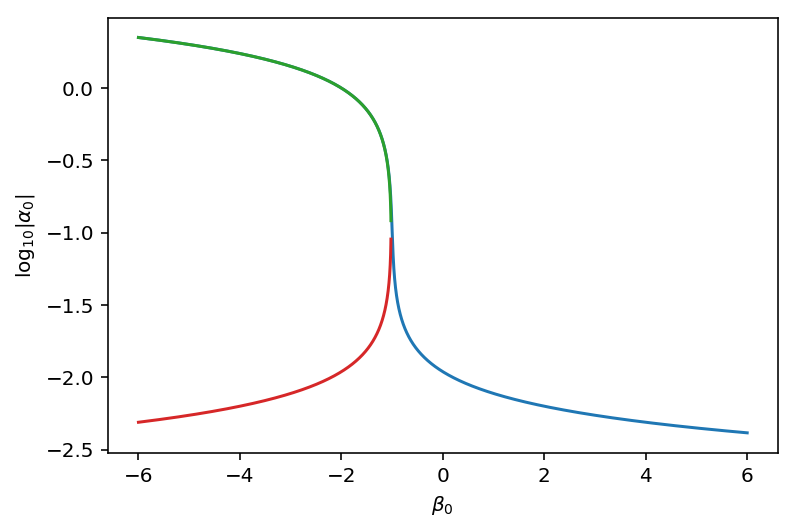

In [42]:
def llr_sol(b, l, sgn):
    return np.sqrt((-(b+1-l)+sgn*np.sqrt((b+1-l)**2+l*(2-l)))
            /(2-l))
betas_llr = np.linspace(-6,6,10000)
alphas_llr = []
for l, sgn in [(llr_eta,1),(llr_eta,-1),(-llr_eta,1),(-llr_eta,-1)]:
    a = llr_sol(betas_llr, l, sgn)
    a[a<0] = np.inf
    alphas_llr.append(a)
    plt.plot(betas_llr, np.log10(a))
plt.xlabel(r"$\beta_0$")
plt.ylabel(r"$\log_{10}|\alpha_0|$")


In [43]:
# Messenger limit
mess_eta = 2.1e-4

betas_mess = np.linspace(-6,6,10000)
alphas_mess = []
for l, sgn in [(mess_eta,1),(mess_eta,-1),(-mess_eta,1),(-mess_eta,-1)]:
    a = llr_sol(betas_mess, l, sgn)
    a[a<0] = np.inf
    alphas_mess.append(a)


/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


## Multiple constraints

In [44]:
nscn = "ns_cache.pickle"
if os.path.exists(nscn):
    ns_cache = pickle.load(open(nscn,"rb"))
    print(len(ns_cache))
all_map_new = {}
for (p_c, phi_c, beta_0), d in ns_cache.items():
    if beta_0 not in all_map_new:
        all_map_new[beta_0] = {}
    alpha_map = all_map_new[beta_0]
    if phi_c not in alpha_map:
        alpha_map[phi_c] = []
    mr_curve = alpha_map[phi_c]
    mr_curve.append((p_c, d))
    mr_curve.sort()
all_map = all_map_new

1107641


In [45]:
betas = np.linspace(-6, 6.01, 81) # can't have beta=0
betas = np.unique(np.concatenate(  # unique also sorts
    [betas, 
     np.linspace(-2, -1, 11),
     np.linspace(-1.6, -1.3, 11),
     np.linspace(-1.5, -1.4, 11),
     np.linspace(-1.46, -1.42, 11),
     np.linspace(-1.445, -1.440, 11),
     np.linspace(-1.450, -1.445, 11),
    ]))


In [57]:
cassini_limit = 3.4e-3
alphas_cassini = cassini_limit*np.ones_like(betas)

In [58]:
# 0.005 is aa 95% upper limit from Antoniadis et al.
def condition_0348(d):
    return (np.abs(d["alpha_A"] - d["alpha_0"]) - 0.005)
mass_0348 = 2.0
alphas_0348 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_0348,
                                         condition_0348)

Exploring for beta=-6.000000
1e-06 1.5408761239e-06
1 -5.81694304579
1e-06 1.5408761239e-06
1 -5.81694304579
0.177453015479 0.137982782649
0.177456403272 0.137980196027
0.182359581327 0.133929177591
0.253601216775 7.79137713014e-07
0.253601483949 -4.0985714822e-11
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
brentq with 0.253601483934 -1.51861856423e-12 0.253601483935 2.186584247e-13 xtol 1e-12
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
phi_c_0 0.253601483935
0.253601483935 0 condition: 0.642814993224
No solution
Exploring for beta=-5.849875
1e-06 1.37568480472e-06
1 -5.65733944223
1e-06 1.37568480472e-06
1 -5.65733944223
0.164809544147 0.124472364182
0.170271081539 0.12141951655
0.246700335263 3.73918862319e-06
0.246701756804 -2.17418206185e-08
0.246701755991 2.38052318342e-09
0.246701756797 1.66544017022e-10
0.246701756798 -2.17859409948e-08
0.246701756797 1.66544017022e-10
0.24

1 -3.74406544632
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.585035565051
0 0 condition: -0.005
1 1 condition: 0.585035565051
0.0444528213165 0.0444528213165 condition: 0.0650685360324
0.00129308352313 0.00129308352313 condition: -0.00294209167631
0.00184285424832 0.00184285424832 condition: -0.00206717058802
0.00314186724622 0.00314186724622 condition: -9.8745664423e-14
0.00314187015361 0.00314187015361 condition: 4.62640126816e-09
0.00314186724672 0.00314186724672 condition: 6.82132302032e-13
0.00314186724622 0.00314186724622 condition: -9.8745664423e-14
0.00314186724672 0.00314186724672 condition: 6.82132302032e-13
brentq with 0.00314186724622 -9.8745664423e-14 0.00314186724672 6.82132302032e-13 xtol 1e-12
0.00314186724622 0.00314186724622 condition: -9.8745664423e-14
0.00314186724672 0.00314186724672 condition: 6.82132302032e-13
returning 0.00314186724622 -0.000768238387571 -9.8745664423e-14
Exploring for beta=-3.898250
1e-06 -3.43547027508e-07
1 -3.58

0.00271215291203 0.00271215291203 condition: -0.00350427917793
0.00456934770394 0.00456934770394 condition: -0.00248019299183
0.00906904164925 0.00906904164925 condition: -1.26575071605e-10
0.00906904186999 0.00906904186999 condition: -1.67767102294e-12
0.00906904187098 0.00906904187098 condition: -3.62740306542e-12
0.00906904187098 0.00906904187098 condition: -3.62740306542e-12
0.0090690418717 0.0090690418717 condition: 6.82611866337e-12
brentq with 0.00906904187098 -3.62740306542e-12 0.0090690418717 6.82611866337e-12 xtol 1e-12
0.00906904187098 0.00906904187098 condition: -3.62740306542e-12
0.0090690418717 0.0090690418717 condition: 6.82611866337e-12
returning 0.00906904187098 -0.00766569577644 -3.62740306542e-12
Exploring for beta=-2.697250
1e-06 -8.86532186989e-07
1 -2.3670051753
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.376749496567
0 0 condition: -0.005
1 1 condition: 0.376749496567
0.0111365719663 0.0111365719663 condition: -1.0996490437e-10
0.089

0.356536525386 0.356536525386 condition: -5.46900979365e-12
0.356536525387 0.356536525387 condition: -9.14930457785e-13
0.356536525387 0.356536525387 condition: -9.14930457785e-13
0.356536525388 0.356536525388 condition: 1.87450489159e-12
brentq with 0.356536525387 -9.14930457785e-13 0.356536525388 1.87450489159e-12 xtol 1e-12
0.356536525387 0.356536525387 condition: -9.14930457785e-13
0.356536525388 0.356536525388 condition: 1.87450489159e-12
returning 0.356536525387 -0.386170601997 -9.14930457785e-13
Exploring for beta=-1.800000
1e-06 -9.55739527083e-07
1 -1.52883289981
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.218041987208
0 0 condition: -0.005
1 1 condition: 0.218041987208
0.226509654855 0.226509654855 condition: -0.000988559018525
0.249822417964 0.249822417964 condition: -3.48951196931e-10
0.474811762157 0.474811762157 condition: 0.028299561803
0.249822425402 0.249822425402 condition: 5.99670747087e-12
0.249822425359 0.249822425359 condition: -2.135

1 -1.26763199025
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.17442704815
0 0 condition: -0.005
1 1 condition: 0.17442704815
0.248466721336 0.248466721336 condition: 0.019039307759
0.0132479339268 0.0132479339268 condition: -0.00363414498298
0.166670592219 0.166670592219 condition: 0.0115043122201
0.0486888819332 0.0486888819332 condition: -3.95282940424e-07
0.0486927643596 0.0486927643596 condition: -9.24980578243e-14
0.0486927643628 0.0486927643628 condition: 8.33774889408e-13
0.0486927643601 0.0486927643601 condition: 9.53276520221e-13
0.0486927643596 0.0486927643596 condition: -9.24980578243e-14
0.0486927643601 0.0486927643601 condition: 9.53276520221e-13
brentq with 0.0486927643596 -9.24980578243e-14 0.0486927643601 9.53276520221e-13 xtol 1e-12
0.0486927643596 0.0486927643596 condition: -9.24980578243e-14
0.0486927643601 0.0486927643601 condition: 9.53276520221e-13
returning 0.0486927643596 -0.0440990895019 -9.24980578243e-14
Exploring for beta=-1.4962

1 -1.22504963224
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.167944983002
0 0 condition: -0.005
1 1 condition: 0.167944983002
0.181813897394 0.181813897394 condition: 0.0149327014245
0.0389118028461 0.0389118028461 condition: -0.000536553454988
0.0436199775734 0.0436199775734 condition: -7.11384944008e-13
0.181812620916 0.181812620916 condition: 0.0149325714463
0.0553623092373 0.0553623092373 condition: 0.00133279345258
0.0436199775762 0.0436199775762 condition: -1.39614968891e-12
0.0436199775767 0.0436199775767 condition: 4.13798335874e-13
0.0436199775762 0.0436199775762 condition: -1.39614968891e-12
0.0436199775767 0.0436199775767 condition: 4.13798335874e-13
brentq with 0.0436199775762 -1.39614968891e-12 0.0436199775767 4.13798335874e-13 xtol 1e-12
0.0436199775762 0.0436199775762 condition: -1.39614968891e-12
0.0436199775767 0.0436199775767 condition: 4.13798335874e-13
returning 0.0436199775767 -0.0389525818612 4.13798335874e-13
Exploring for beta=-1.45

1 -1.22207868694
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.167500345202
0 0 condition: -0.005
1 1 condition: 0.167500345202
0.176650784628 0.176650784628 condition: 0.0145387183312
0.0765225844753 0.0765225844753 condition: 0.00377137360127
0.0755079298127 0.0755079298127 condition: 0.0036573414341
0.0433179239497 0.0433179239497 condition: 9.93952316286e-13
0.0433166552108 0.0433166552108 condition: -1.45464450286e-07
0.043317923948 0.043317923948 condition: -5.14618729575e-13
0.0433179239486 0.0433179239486 condition: 8.12254170174e-12
0.043317923948 0.043317923948 condition: -5.14618729575e-13
0.0433179239486 0.0433179239486 condition: 8.12254170174e-12
brentq with 0.043317923948 -5.14618729575e-13 0.0433179239486 8.12254170174e-12 xtol 1e-12
0.043317923948 0.043317923948 condition: -5.14618729575e-13
0.0433179239486 0.0433179239486 condition: 8.12254170174e-12
returning 0.043317923948 -0.0386427996333 -5.14618729575e-13
Exploring for beta=-1.446000
1

1 -1.21868485988
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.166993404759
0 0 condition: -0.005
1 1 condition: 0.166993404759
0.170724261457 0.170724261457 condition: 0.0140740609603
0.0554489622434 0.0554489622434 condition: 0.00143642181073
0.0554487351224 0.0554487351224 condition: 0.00143639570943
0.0429800992161 0.0429800992161 condition: -6.48951378746e-14
0.0429800992293 0.0429800992293 condition: 1.41526807634e-12
0.042980099221 0.042980099221 condition: 2.27167330086e-12
0.0429800992166 0.0429800992166 condition: 1.83669919551e-13
0.0429800992161 0.0429800992161 condition: -6.48951378746e-14
0.0429800992166 0.0429800992166 condition: 1.83669919551e-13
brentq with 0.0429800992161 -6.48951378746e-14 0.0429800992166 1.83669919551e-13 xtol 1e-12
0.0429800992161 0.0429800992161 condition: -6.48951378746e-14
0.0429800992166 0.0429800992166 condition: 1.83669919551e-13
returning 0.0429800992161 -0.0382957510772 -6.48951378746e-14
Exploring for beta=-1.44

1 -1.20808992484
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.165421060136
0 0 condition: -0.005
1 1 condition: 0.165421060136
0.152177319332 0.152177319332 condition: 0.0125362131608
0.0301719096779 0.0301719096779 condition: -0.00140011562617
0.148079391452 0.148079391452 condition: 0.0120920903959
0.0419713759846 0.0419713759846 condition: 2.21568223838e-11
0.0419713759727 0.0419713759727 condition: -5.5982200646e-11
0.0419713759824 0.0419713759824 condition: -6.13986457162e-11
0.041971375983 0.041971375983 condition: -2.34929697224e-12
0.0419713759835 0.0419713759835 condition: 1.72049431993e-11
0.041971375983 0.041971375983 condition: -2.34929697224e-12
0.0419713759835 0.0419713759835 condition: 1.72049431993e-11
brentq with 0.041971375983 -2.34929697224e-12 0.0419713759835 1.72049431993e-11 xtol 1e-12
0.041971375983 0.041971375983 condition: -2.34929697224e-12
0.0419713759835 0.0419713759835 condition: 1.72049431993e-11
returning 0.041971375983 -0.037

1 -1.13740847122
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.155271841812
0 0 condition: -0.005
1 1 condition: 0.155271841812
0.067596003906 0.067596003906 condition: 0.00416205458065
0.0112653484153 0.0112653484153 condition: -0.0034613030716
0.0366853687942 0.0366853687942 condition: -1.48734757149e-12
0.0675959986173 0.0675959986173 condition: 0.00416205387228
0.0366853688052 0.0366853688052 condition: 1.44497270052e-11
0.0366853687947 0.0366853687947 condition: 2.19099608248e-11
0.0366853687942 0.0366853687942 condition: -1.48734757149e-12
0.0366853687947 0.0366853687947 condition: 2.19099608248e-11
brentq with 0.0366853687942 -1.48734757149e-12 0.0366853687947 2.19099608248e-11 xtol 1e-12
0.0366853687942 0.0366853687942 condition: -1.48734757149e-12
0.0366853687947 0.0366853687947 condition: 2.19099608248e-11
returning 0.0366853687942 -0.0316711057406 -1.48734757149e-12
Exploring for beta=-1.330000
1e-06 -8.57934855887e-07
1 -1.12389994851
No spontane

0.0364464372289 0.0364464372289 condition: 0.00144919040558
0.0216374720033 0.0216374720033 condition: -0.00116673539279
0.0282360457389 0.0282360457389 condition: -3.55155774581e-11
0.0282360459317 0.0282360459317 condition: 9.52918447275e-11
0.0282360457416 0.0282360457416 condition: 7.77851715331e-11
0.0282360457398 0.0282360457398 condition: -3.54496007202e-11
0.0282360457407 0.0282360457407 condition: 3.4172209333e-11
0.0282360457398 0.0282360457398 condition: -3.54496007202e-11
0.0282360457407 0.0282360457407 condition: 3.4172209333e-11
brentq with 0.0282360457398 -3.54496007202e-11 0.0282360457407 3.4172209333e-11 xtol 1e-12
0.0282360457398 0.0282360457398 condition: -3.54496007202e-11
0.0282360457407 0.0282360457407 condition: 3.4172209333e-11
returning 0.0282360457407 -0.0205761477782 3.4172209333e-11
Exploring for beta=-0.895750
1e-06 -6.76868299439e-07
1 -0.767929656125
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.113138956511
0 0 condition: -0.0

0.744182989615 0.744182989615 condition: 0.054162824615
0.583632373758 0.583632373758 condition: 0.0391589445261
0.0711490635459 0.0711490635459 condition: -2.03889769651e-12
0.0711490635466 0.0711490635466 condition: -1.00052344881e-12
0.0711490635471 0.0711490635471 condition: 1.21117525731e-12
0.0711490635466 0.0711490635466 condition: -1.00052344881e-12
0.0711490635471 0.0711490635471 condition: 1.21117525731e-12
brentq with 0.0711490635466 -1.00052344881e-12 0.0711490635471 1.21117525731e-12 xtol 1e-12
0.0711490635466 0.0711490635466 condition: -1.00052344881e-12
0.0711490635471 0.0711490635471 condition: 1.21117525731e-12
returning 0.0711490635466 0.011529409433 -1.00052344881e-12
Exploring for beta=0.305250
1e-06 3.32247302837e-07
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
0.0286958000714 0.0286958000714 condition: -0.000698380800882
0.377675609616 0.377675609616 condition: 0.0551264208389
0.0333506137616 0.0333506137616 condition: 1.913833674

0.0131177135751 0.0131177135751 condition: 0.0112231673922
0.00118125118594 0.00118125118594 condition: -0.00353955349247
0.00325074440708 0.00325074440708 condition: -0.000980857132794
0.00404352826765 0.00404352826765 condition: -6.25759785935e-07
0.00404403435538 0.00404403435538 condition: -6.96122846866e-13
0.00404403435595 0.00404403435595 condition: -4.93077800812e-14
0.00404403435645 0.00404403435645 condition: 1.66612036667e-12
0.00404403435595 0.00404403435595 condition: -4.93077800812e-14
0.00404403435645 0.00404403435645 condition: 1.66612036667e-12
brentq with 0.00404403435595 -4.93077800812e-14 0.00404403435645 1.66612036667e-12 xtol 1e-12
0.00404403435595 0.00404403435595 condition: -4.93077800812e-14
0.00404403435645 0.00404403435645 condition: 1.66612036667e-12
returning 0.00404403435595 0.0089129277863 -4.93077800812e-14
Exploring for beta=1.656375
1e-06 2.50638264782e-06
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
0.00348970973442 0

0.001099550872 0.001099550872 condition: -0.00109417527477
0.0192060011785 0.0192060011785 condition: 0.0632804825457
0.0014075758782 0.0014075758782 condition: 1.3333613727e-12
0.00140656413864 0.00140656413864 condition: -3.59393825508e-06
0.00140757582462 0.00140757582462 condition: -1.8839839671e-10
0.00140757587765 0.00140757587765 condition: -1.91989306397e-12
0.00140757587765 0.00140757587765 condition: -1.91989306397e-12
0.0014075758782 0.0014075758782 condition: 1.3333613727e-12
brentq with 0.00140757587765 -1.91989306397e-12 0.0014075758782 1.3333613727e-12 xtol 1e-12
0.00140757587765 0.00140757587765 condition: -1.91989306397e-12
0.0014075758782 0.0014075758782 condition: 1.3333613727e-12
returning 0.0014075758782 0.00779832697954 1.3333613727e-12
Exploring for beta=3.007500
1e-06 6.00153200251e-06
1 0.327049342228
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.306659700618
0 0 condition: -0.005
1 1 condition: 0.306659700618
0.00128514940453 0.0012

0.000220388910563 0.000220388910563 condition: -0.00340082639746
0.000315701436447 0.000315701436447 condition: -0.00270922495713
0.000531844172496 0.000531844172496 condition: -0.0011408618254
0.00068907110584 0.00068907110584 condition: -4.0734750642e-12
0.00068907110634 0.00068907110634 condition: 8.28007801212e-13
0.00068907110584 0.00068907110584 condition: -4.0734750642e-12
0.00068907110634 0.00068907110634 condition: 8.28007801212e-13
brentq with 0.00068907110584 -4.0734750642e-12 0.00068907110634 8.28007801212e-13 xtol 1e-12
0.00068907110584 0.00068907110584 condition: -4.0734750642e-12
0.00068907110634 0.00068907110634 condition: 8.28007801212e-13
returning 0.00068907110634 0.00718167905242 8.28007801212e-13
Exploring for beta=4.358625
1e-06 1.1071970146e-05
1 0.575043229413
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.515785162698
0 0 condition: -0.005
1 1 condition: 0.515785162698
0.000496614997707 0.000496614997707 condition: -0.00114397614991
0

0.00588898191892 0.00588898191892 condition: 0.0692640862239
0.00564855046609 0.00564855046609 condition: 0.0662331016806
0.00405534691992 0.00405534691992 condition: 0.0461455091677
0.000396418644176 0.000396418644176 condition: 9.38025872255e-12
0.000396418643433 0.000396418643433 condition: -1.31106757395e-12
0.000396418644176 0.000396418644176 condition: 9.38025872255e-12
brentq with 0.000396418643433 -1.31106757395e-12 0.000396418644176 9.38025872255e-12 xtol 1e-12
0.000396418643433 0.000396418643433 condition: -1.31106757395e-12
0.000396418644176 0.000396418644176 condition: 9.38025872255e-12
returning 0.000396418643433 0.00679003648264 -1.31106757395e-12
Exploring for beta=5.709750
1e-06 1.79992844983e-05
1 0.619474348211
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.555445194635
0 0 condition: -0.005
1 1 condition: 0.555445194635
0.000288163950893 0.000288163950893 condition: -0.00116090691644
0.00537684821373 0.00537684821373 condition: 0.0666209970

In [59]:
import astropy.units as u
import astropy.constants as c
import numpy as np

# pbdot_1738 = (2.0+3.7-3.6)*1e-15
# pbdot_dipolar = -2*pi*n_b*G*M_c/c**3*(q/(q+1))*(1+e**2/2)/(1-e**2)**(5/2)*(alpha_p-alpha_0)**2
# Now what are all those quantities? n_b = 2*pi/P_b
# P_b = 0.354 790 739 8724(13) d
# M_c = 0.181(8)
# e = 3.4(1.1)e-7

# 2 sigma upper limit
pbdot_1738 = 9.4e-15
P_b_1738 = 0.3547907398724*u.day
M_c_1738 = 0.181*u.Msun
e_1738 = 3.4e-7
n_b_1738 = 2*np.pi/P_b_1738
q_1738 = 8.1
sqlimit_1738 = (pbdot_1738
                /(2*np.pi*n_b_1738*c.G*M_c_1738/c.c**3)
                /(q_1738/(q_1738+1))
                /((1+e_1738**2/2)/(1-e_1738**2)**(5/2.)))
limit_1738 = np.sqrt(float(sqlimit_1738))
limit_1738

0.0030323604065338682

In [60]:

def condition_1738(d):
    return (np.abs(d["alpha_A"] - d["alpha_0"]) - limit_1738)
mass_1738 = 1.46
#lim_1738 = pbdot_1738*c**3/

alphas_1738 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_1738,
                                         condition_1738)

Exploring for beta=-6.000000
1e-06 7.83235993621e-07
1 -5.85273802147
1e-06 7.83235993621e-07
1 -5.85273802147
0.177453015479 0.00735528359436
0.177456403272 0.00735040779109
0.182359581327 1.60588209397e-12
0.253601216775 -0.177425296148
0.182360176397 -9.27013547009e-07
0.182359581328 -6.24400531279e-12
0.182359581327 1.60588209397e-12
0.182359581328 -6.24400531279e-12
brentq with 0.182359581327 -1.60588209397e-12 0.182359581328 6.24400531279e-12 xtol 1e-12
0.182359581327 1.60588209397e-12
0.182359581328 -6.24400531279e-12
phi_c_0 0.182359581327
0.182359581327 0 condition: 0.548805532895
No solution
Exploring for beta=-5.849875
1e-06 6.43612969358e-07
1 -5.69478494243
1e-06 6.43612969358e-07
1 -5.69478494243
0.164809544147 0.00668735039411
0.170271081539 5.02292185041e-10
0.246700335263 -0.167891757897
0.1702710823 -5.02636808251e-10
0.170271081929 -3.83185289055e-12
0.170271081918 1.03031550579e-09
0.170271081928 1.97914389963e-11
0.170271081928 1.97914389963e-11
0.170271081929 -3.8

1 -4.11364306877
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.524444255876
0 0 condition: -0.00303236040653
1 1 condition: 0.524444255876
0.0437878070296 0.0437878070296 condition: 0.0809194476171
0.00136232005898 0.00136232005898 condition: -0.000389672640195
0.00162398378038 0.00162398378038 condition: 0.000117899040831
0.00156320400632 0.00156320400632 condition: -2.67414996397e-13
0.00156321119617 0.00156321119617 condition: 1.39468034582e-08
0.00156320400682 0.00156320400682 condition: 8.76437377534e-13
0.00156320400632 0.00156320400632 condition: -2.67414996397e-13
0.00156320400682 0.00156320400682 condition: 8.76437377534e-13
brentq with 0.00156320400632 -2.67414996397e-13 0.00156320400682 8.76437377534e-13 xtol 1e-12
0.00156320400632 0.00156320400632 condition: -2.67414996397e-13
0.00156320400682 0.00156320400682 condition: 8.76437377534e-13
returning 0.00156320400632 -0.000783509065906 -2.67414996397e-13
Exploring for beta=-4.198500
1e-0

1 1 condition: 0.397141556345
0.00345669810323 0.00345669810323 condition: 1.70431637553e-11
0.0014480977646 0.0014480977646 condition: -0.00176195909605
0.00172625131291 0.00172625131291 condition: -0.00151794524539
0.00205222163033 0.00205222163033 condition: -0.00123198848236
0.00345669808327 0.00345669808327 condition: 3.06611073336e-13
0.00345669808277 0.00345669808277 condition: -3.02895729332e-13
0.00345669808277 0.00345669808277 condition: -3.02895729332e-13
0.00345669808327 0.00345669808327 condition: 3.06611073336e-13
brentq with 0.00345669808277 -3.02895729332e-13 0.00345669808327 3.06611073336e-13 xtol 1e-12
0.00345669808277 0.00345669808277 condition: -3.02895729332e-13
0.00345669808327 0.00345669808327 condition: 3.06611073336e-13
returning 0.00345669808277 -0.00351791347743 -3.02895729332e-13
Exploring for beta=-2.997500
1e-06 -1.0525826897e-06
1 -2.72345696638
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.374903900719
0 0 condition

1 -1.76064081383
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.2161855431
0 0 condition: -0.00303236040653
1 1 condition: 0.2161855431
0.0760110092759 0.0760110092759 condition: 0.0110522958854
0.00355682580838 0.00355682580838 condition: -0.00235102158353
0.0158515658167 0.0158515658167 condition: -7.71384258552e-13
0.036787210499 0.036787210499 condition: 0.00396067569021
0.0158515658189 0.0158515658189 condition: 4.2984582907e-13
0.0158515658176 0.0158515658176 condition: -6.68494266019e-11
0.0158515658181 0.0158515658181 condition: 4.09589896722e-14
0.0158515658176 0.0158515658176 condition: -6.68494266019e-11
0.0158515658181 0.0158515658181 condition: 4.09589896722e-14
brentq with 0.0158515658176 -6.68494266019e-11 0.0158515658181 4.09589896722e-14 xtol 1e-12
0.0158515658176 0.0158515658176 condition: -6.68494266019e-11
0.0158515658181 0.0158515658181 condition: 4.09589896722e-14
returning 0.0158515658181 -0.0173470218829 4.09589896722e-14
Ex

1 -1.37143375633
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.154889541443
0 0 condition: -0.00303236040653
1 1 condition: 0.154889541443
0.106471066591 0.106471066591 condition: 2.11112504431e-09
0.0565252938149 0.0565252938149 condition: -0.00123236041185
0.0592891342118 0.0592891342118 condition: -0.00115225008047
0.10647094383 0.10647094383 condition: -3.50147124836e-12
0.106470943988 0.106470943988 condition: 3.20942722485e-10
0.106470943985 0.106470943985 condition: -1.87536921756e-12
0.106470943986 0.106470943986 condition: 3.24259152949e-10
0.106470943985 0.106470943985 condition: -1.87536921756e-12
0.106470943986 0.106470943986 condition: 3.24259152949e-10
brentq with 0.106470943985 -1.87536921756e-12 0.106470943986 3.24259152949e-10 xtol 1e-12
0.106470943985 0.106470943985 condition: -1.87536921756e-12
0.106470943986 0.106470943986 condition: 3.24259152949e-10
returning 0.106470943985 -0.107282039587 -1.87536921756e-12
Exploring for bet

1 -1.27455565624
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.141211078215
0 0 condition: -0.00303236040653
1 1 condition: 0.141211078215
0.218562615632 0.218562615632 condition: -0.000453116548413
0.382152321926 0.382152321926 condition: 0.0114827820446
0.303405114701 0.303405114701 condition: 0.00425774897287
0.229627341248 0.229627341248 condition: -3.35846594892e-10
0.229627341303 0.229627341303 condition: 3.63600594945e-11
0.229627341265 0.229627341265 condition: 4.70784417093e-10
0.229627341249 0.229627341249 condition: 3.22822635377e-10
0.229627341248 0.229627341248 condition: -3.35846594892e-10
0.229627341249 0.229627341249 condition: 3.22822635377e-10
brentq with 0.229627341248 -3.35846594892e-10 0.229627341249 3.22822635377e-10 xtol 1e-12
0.229627341248 0.229627341248 condition: -3.35846594892e-10
0.229627341249 0.229627341249 condition: 3.22822635377e-10
returning 0.229627341249 -0.227428092907 3.22822635377e-10
Exploring for beta=-1.4

1 -1.26405048767
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.139778139184
0 0 condition: -0.00303236040653
1 1 condition: 0.139778139184
0.178869145048 0.178869145048 condition: -0.00123239550054
0.37089146112 0.37089146112 condition: 0.0109197405423
0.180398336604 0.180398336604 condition: -0.00118920282526
0.221054897671 0.221054897671 condition: 0.000221030218008
0.215597150338 0.215597150338 condition: -9.19957989995e-12
0.215597150339 0.215597150339 condition: 4.62064284404e-12
0.215597150339 0.215597150339 condition: 4.05007147611e-12
0.215597150338 0.215597150338 condition: -9.19957989995e-12
0.215597150339 0.215597150339 condition: 4.05007147611e-12
brentq with 0.215597150338 -9.19957989995e-12 0.215597150339 4.05007147611e-12 xtol 1e-12
0.215597150338 0.215597150338 condition: -9.19957989995e-12
0.215597150339 0.215597150339 condition: 4.05007147611e-12
returning 0.215597150339 -0.211891551423 4.05007147611e-12
Exploring for beta=-1.447

1 -1.26055133929
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.13930312191
0 0 condition: -0.00303236040653
1 1 condition: 0.13930312191
0.172953334308 0.172953334308 condition: -0.00123236040228
0.369514696399 0.369514696399 condition: 0.010991787307
0.210826992284 0.210826992284 condition: -2.63619117855e-12
0.210920888743 0.210920888743 condition: 3.60943635769e-06
0.210826992291 0.210826992291 condition: 1.49034174758e-11
0.210826992284 0.210826992284 condition: -2.64823709836e-12
0.210826992285 0.210826992285 condition: 8.68053415606e-12
0.210826992284 0.210826992284 condition: -2.64823709836e-12
0.210826992285 0.210826992285 condition: 8.68053415606e-12
brentq with 0.210826992284 -2.64823709836e-12 0.210826992285 8.68053415606e-12 xtol 1e-12
0.210826992284 0.210826992284 condition: -2.64823709836e-12
0.210826992285 0.210826992285 condition: 8.68053415606e-12
returning 0.210826992284 -0.206676513838 -2.64823709836e-12
Exploring for beta=-1.44

1 -1.25705375201
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.138829998426
0 0 condition: -0.00303236040653
1 1 condition: 0.138829998426
0.167002654654 0.167002654654 condition: -0.00123236040857
0.375628170738 0.375628170738 condition: 0.0118483123353
0.206021579642 0.206021579642 condition: 6.49950102419e-12
0.173186064743 0.173186064743 condition: -0.00106628140565
0.20602157955 0.20602157955 condition: -4.24362758475e-12
0.206021579585 0.206021579585 condition: 5.68004540971e-12
0.206021579584 0.206021579584 condition: -2.31281573754e-13
0.206021579584 0.206021579584 condition: -2.31281573754e-13
0.206021579585 0.206021579585 condition: 5.68004540971e-12
brentq with 0.206021579584 -2.31281573754e-13 0.206021579585 5.68004540971e-12 xtol 1e-12
0.206021579584 0.206021579584 condition: -2.31281573754e-13
0.206021579585 0.206021579585 condition: 5.68004540971e-12
returning 0.206021579584 -0.201455292978 -2.31281573754e-13
Exploring for beta=-1.4

1 -1.22215047757
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.134171175974
0 0 condition: -0.00303236040653
1 1 condition: 0.134171175974
0.11172996182 0.11172996182 condition: -0.00123236040246
0.362659206307 0.362659206307 condition: 0.0126197436472
0.158408197596 0.158408197596 condition: 4.16793271207e-07
0.15839511896 0.15839511896 condition: -1.05402574689e-11
0.158395118967 0.158395118967 condition: 1.85163559832e-12
0.158395118966 0.158395118966 condition: 8.32656730024e-12
0.158395118965 0.158395118965 condition: -2.42952316251e-12
0.158395118965 0.158395118965 condition: -2.42952316251e-12
0.158395118966 0.158395118966 condition: 8.32656730024e-12
brentq with 0.158395118965 -2.42952316251e-12 0.158395118966 8.32656730024e-12 xtol 1e-12
0.158395118965 0.158395118965 condition: -2.42952316251e-12
0.158395118966 0.158395118966 condition: 8.32656730024e-12
returning 0.158395118965 -0.151201618833 -2.42952316251e-12
Exploring for beta=-1.390

0.308140448891 0.308140448891 condition: 0.0170283344263
0.297567233382 0.297567233382 condition: 0.0161552268195
0.297567231444 0.297567231444 condition: 0.0161552266705
0.164701290211 0.164701290211 condition: 0.00659282087508
0.0541098231817 0.0541098231817 condition: 3.57874016879e-12
0.0541098231812 0.0541098231812 condition: -8.00483811181e-14
0.0541098231817 0.0541098231817 condition: 3.57874016879e-12
brentq with 0.0541098231812 -8.00483811181e-14 0.0541098231817 3.57874016879e-12 xtol 1e-12
0.0541098231812 0.0541098231812 condition: -8.00483811181e-14
0.0541098231817 0.0541098231817 condition: 3.57874016879e-12
returning 0.0541098231812 -0.0465805624804 -8.00483811181e-14
Exploring for beta=-1.100000
1e-06 -8.14604490512e-07
1 -0.964225604232
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.103822158903
0 0 condition: -0.00303236040653
1 1 condition: 0.103822158903
0.0427274065033 0.0427274065033 condition: 3.0900336543e-11
0.0132569153246 0

0.0231915358153 0.0231915358153 condition: -0.00218601297409
0.0493376865324 0.0493376865324 condition: -0.00123236040401
0.0831715228051 0.0831715228051 condition: -1.31311623901e-11
0.083171522813 0.083171522813 condition: 1.45949658609e-13
0.0831715228071 0.0831715228071 condition: 4.80198563205e-12
0.0831715228061 0.0831715228061 condition: 7.86202396588e-12
0.0831715228051 0.0831715228051 condition: -1.31311623901e-11
0.0831715228061 0.0831715228061 condition: 7.86202396588e-12
brentq with 0.0831715228051 -1.31311623901e-11 0.0831715228061 7.86202396588e-12 xtol 1e-12
0.0831715228051 0.0831715228051 condition: -1.31311623901e-11
0.0831715228061 0.0831715228061 condition: 7.86202396588e-12
returning 0.0831715228061 -0.0116393521413 7.86202396588e-12
Exploring for beta=0.005000
1e-06 5.00619497696e-09
1 0.00500621348738
No spontaneous scalarization found
0 0 condition: -0.00303236040653
0 0 condition: -0.00303236040653
10.0 10.0 condition: 0.0251997261798
1.26294345431 1.26294345431

0.0674517345225 0.0674517345225 condition: 0.041890728994
0.014826235895 0.014826235895 condition: 0.00677066479844
0.00564462334427 0.00564462334427 condition: 0.000698662462409
0.00514887760778 0.00514887760778 condition: 0.000370950224732
0.00458770837797 0.00458770837797 condition: 2.19315451216e-13
0.00458770837747 0.00458770837747 condition: -4.11819016388e-14
0.00458770837797 0.00458770837797 condition: 2.19315451216e-13
brentq with 0.00458770837747 -4.11819016388e-14 0.00458770837797 2.19315451216e-13 xtol 1e-12
0.00458770837747 0.00458770837747 condition: -4.11819016388e-14
0.00458770837797 0.00458770837797 condition: 2.19315451216e-13
returning 0.00458770837747 0.00727649421373 -4.11819016388e-14
Exploring for beta=1.356125
1e-06 1.8399067164e-06
1 0.604495345974
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.548436933971
0 0 condition: -0.00303236040653
1 1 condition: 0.548436933971
0.00474309816527 0.00474309816527 condition: 0.00072049

0.0220704172881 0.0220704172881 condition: 0.0469844598242
0.00170857693789 0.00170857693789 condition: 0.000832632946762
0.00134050494921 0.00134050494921 condition: 1.39856507451e-11
0.00134050494728 0.00134050494728 condition: -5.95817666038e-12
0.00134050494778 0.00134050494778 condition: 4.87824190765e-12
0.00134050494728 0.00134050494728 condition: -5.95817666038e-12
0.00134050494778 0.00134050494778 condition: 4.87824190765e-12
brentq with 0.00134050494728 -5.95817666038e-12 0.00134050494778 4.87824190765e-12 xtol 1e-12
0.00134050494728 0.00134050494728 condition: -5.95817666038e-12
0.00134050494778 0.00134050494778 condition: 4.87824190765e-12
returning 0.00134050494778 0.00585810384332 4.87824190765e-12
Exploring for beta=2.707250
1e-06 4.75263998129e-06
1 1.06246846155
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 0.903724091258
0 0 condition: -0.00303236040653
1 1 condition: 0.903724091258
0.00121139943354 0.00121139943354 condition: 1.24

0.000793656115116 0.000793656115116 condition: 0.000889108076468
0.000236424156254 0.000236424156254 condition: -0.00186418822134
0.000364298434079 0.000364298434079 condition: -0.00123236040656
0.000613712637026 0.000613712637026 condition: 7.2481083635e-14
0.000613712182806 0.000613712182806 condition: -2.2443149522e-09
0.000613712636526 0.000613712636526 condition: -2.66751334563e-12
0.000613712636526 0.000613712636526 condition: -2.66751334563e-12
0.000613712637026 0.000613712637026 condition: 7.2481083635e-14
brentq with 0.000613712636526 -2.66751334563e-12 0.000613712637026 7.2481083635e-14 xtol 1e-12
0.000613712636526 0.000613712636526 condition: -2.66751334563e-12
0.000613712637026 0.000613712637026 condition: 7.2481083635e-14
returning 0.000613712637026 0.00515427515394 7.2481083635e-14
Exploring for beta=4.058375
1e-06 8.93164434008e-06
1 1.58570324639
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 1.35201376669
0 0 condition: -0.0030323604

0.000132423160804 0.000132423160804 condition: -0.00192246305448
0.000157858882114 0.000157858882114 condition: -0.00170927491134
0.000214760084142 0.000214760084142 condition: -0.00123236040699
0.000361794131407 0.000361794131407 condition: -8.63129677106e-10
0.000361794233888 0.000361794233888 condition: -4.12475175543e-12
0.000361794233888 0.000361794233888 condition: -4.12475175543e-12
0.000361794234388 0.000361794234388 condition: 2.10993332181e-12
brentq with 0.000361794233888 -4.12475175543e-12 0.000361794234388 2.10993332181e-12 xtol 1e-12
0.000361794233888 0.000361794233888 condition: -4.12475175543e-12
0.000361794234388 0.000361794234388 condition: 2.10993332181e-12
returning 0.000361794234388 0.00477171587712 2.10993332181e-12
Exploring for beta=5.259375
1e-06 1.38759872754e-05
1 1.88982189177
No spontaneous scalarization found
0 0 condition: -0.00303236040653
1 1 condition: 1.63323393033
0 0 condition: -0.00303236040653
1 1 condition: 1.63323393033
0.000341129389372 0.00034

In [ ]:
# Existing SEP limit 0.002 based on Zhu et al. 2018
def condition_existing_SEP(d):
    return (np.abs(d["Delta"]) - 2e-3)
mass_existing_SEP = 1.33 # 1713
# FIXME: assumes all NSs have the same mass

alphas_existing_SEP = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_existing_SEP,
                                         condition_existing_SEP)

array([ 0.09873472,  0.09543836,  0.088     ,  0.08331837,  0.08160829])

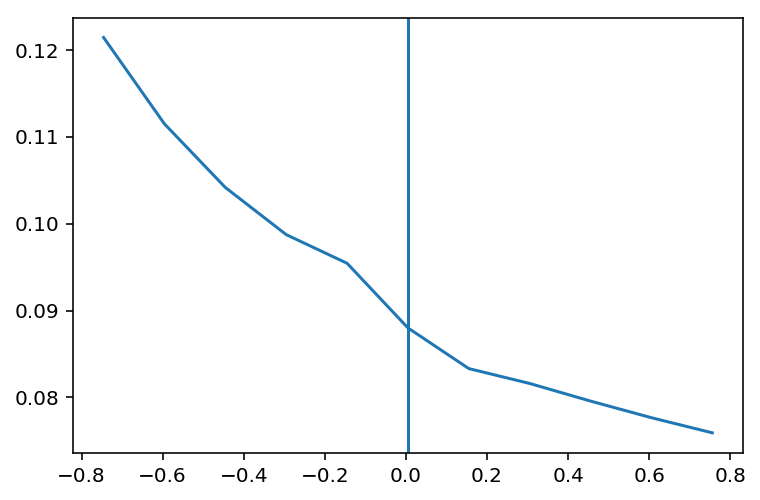

In [83]:
i = np.argmin(np.abs(betas))
alphas_existing_SEP[i] = 0.088 # numerical problems for beta too close to zero
n=5
plt.plot(betas[i-n:i+n+1], np.abs(alphas_existing_SEP[i-n:i+n+1]))
plt.axvline(betas[i])
np.abs(alphas_existing_SEP[i-2:i+3])

In [63]:
def condition_0337(d):
    return (np.abs(d["Delta"]) - 2.7e-6)
mass_0337 = 1.4378
alphas_0337 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_0337,
                                         condition_0337)
alphas_0337

Exploring for beta=-6.000000
1e-06 7.37919743106e-07
1 -5.85430958467
1e-06 7.37919743106e-07
1 -5.85430958467
0.175873198728 0.00229509725066
0.177455395302 -3.50976904231e-06
0.177455017738 -2.95421131541e-06
0.177453015364 2.16957535271e-10
0.177453015478 -2.01014205281e-12
0.177453015476 5.8079374643e-12
0.177453015477 1.38122846494e-11
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
brentq with 0.177453015477 -1.38122846494e-11 0.177453015478 2.01014205281e-12 xtol 1e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
phi_c_0 0.177453015478
0.177453015478 0 condition: -2.69999891143e-06
1.0 0.822546984522 condition: 3.01798136756
0.177453015478 0.0 condition: -2.69999891143e-06
1.0 0.822546984522 condition: 3.01798136756
0.177456403269 3.38779106429e-06 condition: -7.32448644112e-10
0.182359581326 0.00490656584784 condition: 0.00412177036053
0.177456403301 3.38782329221e-06 condition: 1.21581566484e-10
0.177456403274 3.38779604334e-06 conditio

0.0862750463333 0.0135837322474 condition: 0.000759303707858
0.0727644610758 7.31469898494e-05 condition: -1.30083485012e-10
0.0727644683171 7.31542311809e-05 condition: 3.57738642183e-10
0.0727644611075 7.3147021597e-05 condition: 7.87426790011e-11
0.0727644610797 7.31469938178e-05 condition: 1.32616487164e-10
0.0727644610777 7.31469918145e-05 condition: -6.02226428202e-11
0.0727644610789 7.31469929794e-05 condition: -1.42844465168e-10
0.0727644610789 7.31469929794e-05 condition: -1.42844465168e-10
0.0727644610797 7.31469938178e-05 condition: 1.32616487164e-10
brentq with 7.31469929794e-05 -1.42844465168e-10 7.31469938178e-05 1.32616487164e-10 xtol 1e-12
0.0727644610789 7.31469929794e-05 condition: -1.42844465168e-10
0.0727644610797 7.31469938178e-05 condition: 1.32616487164e-10
returning 0.0727644610797 -1.31971580223e-05 1.32616487164e-10
Exploring for beta=-5.099250
1e-06 -2.5767733773e-08
1 -4.90552703202
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 2.

1 1 condition: 1.90761631286
0 0 condition: -2.7e-06
1 1 condition: 1.90761631286
0.0387560771814 0.0387560771814 condition: 0.00172158160376
0.00154145121983 0.00154145121983 condition: -1.00434947817e-11
0.00314187015361 0.00314187015361 condition: 8.51764407979e-06
0.00184285424882 0.00184285424882 condition: 1.15911411551e-06
0.0015414540869 0.0015414540869 condition: 6.25142925842e-16
0.0015414540864 0.0015414540864 condition: -1.19586652592e-15
0.0015414540864 0.0015414540864 condition: -1.19586652592e-15
0.0015414540869 0.0015414540869 condition: 6.25142925842e-16
brentq with 0.0015414540864 -1.19586652592e-15 0.0015414540869 6.25142925842e-16 xtol 1e-12
0.0015414540864 0.0015414540864 condition: -1.19586652592e-15
0.0015414540869 0.0015414540869 condition: 6.25142925842e-16
returning 0.0015414540869 -0.00106806253196 6.25142925842e-16
Exploring for beta=-3.898250
1e-06 -7.6564090815e-07
1 -3.64612072965
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 1

1 -2.42856983137
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.798080979521
0 0 condition: -2.7e-06
1 1 condition: 0.798080979521
0.0111385805908 0.0111385805908 condition: 7.54544309545e-05
0.00318262274588 0.00318262274588 condition: 3.6826169334e-06
0.00173643421233 0.00173643421233 condition: -8.00000375408e-07
0.00205290014395 0.00205290014395 condition: -4.4348482553e-08
0.00206997073859 0.00206997073859 condition: -8.60022621017e-16
0.00206997073909 0.00206997073909 condition: 8.05238647571e-16
0.00206997073859 0.00206997073859 condition: -8.60022621017e-16
0.00206997073909 0.00206997073909 condition: 8.05238647571e-16
brentq with 0.00206997073859 -8.60022621017e-16 0.00206997073909 8.05238647571e-16 xtol 1e-12
0.00206997073859 0.00206997073859 condition: -8.60022621017e-16
0.00206997073909 0.00206997073909 condition: 8.05238647571e-16
returning 0.00206997073909 -0.00230531246348 8.05238647571e-16
Exploring for beta=-2.547125
1e-06 -1.12534708102e-0

1 -1.57968978118
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.296704230524
0 0 condition: -2.7e-06
1 1 condition: 0.296704230524
0.127781587361 0.127781587361 condition: 0.00178155626004
0.016291950282 0.016291950282 condition: 2.92427411267e-05
0.00397057102466 0.00397057102466 condition: -8.00000154124e-07
0.00473332499136 0.00473332499136 condition: -4.53747968899e-14
0.00473332503115 0.00473332503115 condition: 1.39420928551e-14
0.0047333250224 0.0047333250224 condition: -6.36507143379e-17
0.0047333250229 0.0047333250229 condition: 3.77454398439e-15
0.0047333250224 0.0047333250224 condition: -6.36507143379e-17
0.0047333250229 0.0047333250229 condition: 3.77454398439e-15
brentq with 0.0047333250224 -6.36507143379e-17 0.0047333250229 3.77454398439e-15 xtol 1e-12
0.0047333250224 0.0047333250224 condition: -6.36507143379e-17
0.0047333250229 0.0047333250229 condition: 3.77454398439e-15
returning 0.0047333250224 -0.00504470443516 -6.36507143379e-17
Explorin

1 -1.31154823488
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.193781914838
0 0 condition: -2.7e-06
1 1 condition: 0.193781914838
0.248466721362 0.248466721362 condition: 0.000307023372807
0.0132479339365 0.0132479339365 condition: 8.74596839314e-15
0.0111069914121 0.0111069914121 condition: -8.00000769256e-07
0.0132479117669 0.0132479117669 condition: -8.99926179431e-12
0.0132479339246 0.0132479339246 condition: -4.1612708525e-15
0.0132479339268 0.0132479339268 condition: 3.54041094876e-15
0.0132479339261 0.0132479339261 condition: -1.53401774858e-15
0.0132479339261 0.0132479339261 condition: -1.53401774858e-15
0.0132479339268 0.0132479339268 condition: 3.54041094876e-15
brentq with 0.0132479339261 -1.53401774858e-15 0.0132479339268 3.54041094876e-15 xtol 1e-12
0.0132479339261 0.0132479339261 condition: -1.53401774858e-15
0.0132479339268 0.0132479339268 condition: 3.54041094876e-15
returning 0.0132479339261 -0.0130270490865 -1.53401774858e-15
Exploring fo

1 -1.2676296499
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.179648948134
0 0 condition: -2.7e-06
1 1 condition: 0.179648948134
0.183680813288 0.183680813288 condition: 0.000248348561365
0.0389118233376 0.0389118233376 condition: -8.75771668887e-12
0.0779734075128 0.0779734075128 condition: 1.65984890953e-07
0.0389943277539 0.0389943277539 condition: 8.66738932222e-09
0.0389118233465 0.0389118233465 condition: 1.54791582574e-11
0.0389118233407 0.0389118233407 condition: -3.97641857745e-12
0.0389118233414 0.0389118233414 condition: 1.55192026773e-11
0.0389118233407 0.0389118233407 condition: -3.97641857745e-12
0.0389118233414 0.0389118233414 condition: 1.55192026773e-11
brentq with 0.0389118233407 -3.97641857745e-12 0.0389118233414 1.55192026773e-11 xtol 1e-12
0.0389118233407 0.0389118233407 condition: -3.97641857745e-12
0.0389118233414 0.0389118233414 condition: 1.55192026773e-11
returning 0.0389118233407 -0.0376181434475 -3.97641857745e-12
Exploring for 

1 -1.2645632778
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.178690332576
0 0 condition: -2.7e-06
1 1 condition: 0.178690332576
0.176650784654 0.176650784654 condition: 0.000231318031298
0.0765225848109 0.0765225848109 condition: -8.00012593309e-07
0.0789908601799 0.0789908601799 condition: 5.42412735075e-14
0.0768327954051 0.0768327954051 condition: -7.04728349314e-07
0.0789908600462 0.0789908600462 condition: -1.09931938549e-13
0.0789908601723 0.0789908601723 condition: -6.41468270408e-14
0.0789908601764 0.0789908601764 condition: -1.83750487208e-13
0.0789908601791 0.0789908601791 condition: -1.14591267739e-13
0.0789908601791 0.0789908601791 condition: -1.14591267739e-13
0.0789908601799 0.0789908601799 condition: 5.42412735075e-14
brentq with 0.0789908601791 -1.14591267739e-13 0.0789908601799 5.42412735075e-14 xtol 1e-12
0.0789908601791 0.0789908601791 condition: -1.14591267739e-13
0.0789908601799 0.0789908601799 condition: 5.42412735075e-14
returning 0

1 -1.26106013189
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.177600255614
0 0 condition: -2.7e-06
1 1 condition: 0.177600255614
0.170724261762 0.170724261762 condition: 0.00022499174647
0.0554490762005 0.0554490762005 condition: -1.09999100954e-06
0.0614219704167 0.0614219704167 condition: 6.1093132235e-15
0.0572938702018 0.0572938702018 condition: -7.99999988362e-07
0.0572953569228 0.0572953569228 condition: -7.99750542312e-07
0.0614218036183 0.0614218036183 condition: -3.6458619782e-11
0.0614219704096 0.0614219704096 condition: -2.05266025734e-15
0.0614219704162 0.0614219704162 condition: -1.33593189408e-16
0.0614219704162 0.0614219704162 condition: -1.33593189408e-16
0.0614219704167 0.0614219704167 condition: 6.1093132235e-15
brentq with 0.0614219704162 -1.33593189408e-16 0.0614219704167 6.1093132235e-15 xtol 1e-12
0.0614219704162 0.0614219704162 condition: -1.33593189408e-16
0.0614219704167 0.0614219704167 condition: 6.1093132235e-15
returning 0.0614

1 -1.25012125643
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.174225895813
0 0 condition: -2.7e-06
1 1 condition: 0.174225895813
0.193939721364 0.193939721364 condition: 0.000479422275622
0.0419713759795 0.0419713759795 condition: 2.92846656067e-06
0.0256066240283 0.0256066240283 condition: -8.00000025475e-07
0.0301708257829 0.0301708257829 condition: -2.33665727555e-15
0.0301719096779 0.0301719096779 condition: 2.07589696223e-10
0.0301708257876 0.0301708257876 condition: 2.69118444028e-14
0.0301708257834 0.0301708257834 condition: 1.91653270301e-14
0.0301708257829 0.0301708257829 condition: -2.33665727555e-15
0.0301708257834 0.0301708257834 condition: 1.91653270301e-14
brentq with 0.0301708257829 -2.33665727555e-15 0.0301708257834 1.91653270301e-14 xtol 1e-12
0.0301708257829 0.0301708257829 condition: -2.33665727555e-15
0.0301708257834 0.0301708257834 condition: 1.91653270301e-14
returning 0.0301708257829 -0.0289424915292 -2.33665727555e-15
Exploring for

1 -1.17705045966
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.152860778837
0 0 condition: -2.7e-06
1 1 condition: 0.152860778837
0.106483832415 0.106483832415 condition: 0.000264119087145
0.0112653484185 0.0112653484185 condition: 7.73067468025e-14
0.00945135020801 0.00945135020801 condition: -8.00200023758e-07
0.0109875363459 0.0109875363459 condition: -1.31675825185e-07
0.0112653483963 0.0112653483963 condition: -4.28108988858e-14
0.0112653484153 0.0112653484153 condition: -3.91746074497e-13
0.0112653484179 0.0112653484179 condition: -2.45934707569e-14
0.0112653484179 0.0112653484179 condition: -2.45934707569e-14
0.0112653484185 0.0112653484185 condition: 7.73067468025e-14
brentq with 0.0112653484179 -2.45934707569e-14 0.0112653484185 7.73067468025e-14 xtol 1e-12
0.0112653484179 0.0112653484179 condition: -2.45934707569e-14
0.0112653484185 0.0112653484185 condition: 7.73067468025e-14
returning 0.0112653484179 -0.0104444123637 -2.45934707569e-14
Explorin

0.0368318854001 0.0368318854001 condition: 4.21994732482e-05
0.00903012938042 0.00903012938042 condition: -8.83323989176e-15
0.0357167192855 0.0357167192855 condition: 3.9522924977e-05
0.0211948053496 0.0211948053496 condition: 1.21724515412e-05
0.0090347143 0.0090347143 condition: 2.74255451997e-09
0.00903012939466 0.00903012939466 condition: -6.48475718924e-16
0.00903012939519 0.00903012939519 condition: 3.29910862626e-16
0.00903012939466 0.00903012939466 condition: -6.48475718924e-16
0.00903012939519 0.00903012939519 condition: 3.29910862626e-16
brentq with 0.00903012939466 -6.48475718924e-16 0.00903012939519 3.29910862626e-16 xtol 1e-12
0.00903012939466 0.00903012939466 condition: -6.48475718924e-16
0.00903012939519 0.00903012939519 condition: 3.29910862626e-16
returning 0.00903012939519 -0.00359067792555 3.29910862626e-16
Exploring for beta=-0.295250
1e-06 -2.74128712014e-07
1 -0.277856424844
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.0139248882456

0.00854966168505 0.00854966168505 condition: 1.91101087168e-05
0.00317819044909 0.00317819044909 condition: 3.1363613321e-07
0.00300826877774 0.00300826877774 condition: 4.42353639341e-16
0.00300826877724 0.00300826877724 condition: -7.90909814719e-16
0.00300826877724 0.00300826877724 condition: -7.90909814719e-16
0.00300826877774 0.00300826877774 condition: 4.42353639341e-16
brentq with 0.00300826877724 -7.90909814719e-16 0.00300826877774 4.42353639341e-16 xtol 1e-12
0.00300826877724 0.00300826877724 condition: -7.90909814719e-16
0.00300826877774 0.00300826877774 condition: 4.42353639341e-16
returning 0.00300826877774 0.00270898398428 4.42353639341e-16
Exploring for beta=0.905750
1e-06 1.11530011349e-06
1 0.484770634119
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.220385347199
0 0 condition: -2.7e-06
1 1 condition: 0.220385347199
0.0240647282026 0.0240647282026 condition: 0.000273622462574
0.00237967494219 0.00237967494219 condition: 1.08892903985e-15
0.

0.00212325088484 0.00212325088484 condition: 1.62332762182e-05
0.00126036588722 0.00126036588722 condition: 3.97133114325e-06
0.000801835532956 0.000801835532956 condition: 1.54028831822e-10
0.000801812662538 0.000801812662538 condition: 5.53951077175e-17
0.000801812662038 0.000801812662038 condition: -3.30873219109e-15
0.000801812662538 0.000801812662538 condition: 5.53951077175e-17
brentq with 0.000801812662038 -3.30873219109e-15 0.000801812662538 5.53951077175e-17 xtol 1e-12
0.000801812662038 0.000801812662038 condition: -3.30873219109e-15
0.000801812662538 0.000801812662538 condition: 5.53951077175e-17
returning 0.000801812662538 0.0023896573242 5.53951077175e-17
Exploring for beta=2.106750
1e-06 3.30130905502e-06
1 0.866735742825
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 0.654147371372
0 0 condition: -2.7e-06
1 1 condition: 0.654147371372
0.0194470519855 0.0194470519855 condition: 0.00199263605297
0.000715817687916 0.000715817687916 condition: -8.20

0.00716125691467 0.00716125691467 condition: 0.00135948598996
0.000314549423107 0.000314549423107 condition: -7.2624244414e-08
0.000459555210012 0.000459555210012 condition: 2.90815534261e-06
0.000318867075571 0.000318867075571 condition: 7.91378181587e-15
0.000318866701558 0.000318866701558 condition: -6.32598184583e-12
0.000318867075071 0.000318867075071 condition: -5.25273506196e-16
0.000318867075071 0.000318867075071 condition: -5.25273506196e-16
0.000318867075571 0.000318867075571 condition: 7.91378181587e-15
brentq with 0.000318867075071 -5.25273506196e-16 0.000318867075571 7.91378181587e-15 xtol 1e-12
0.000318867075071 0.000318867075071 condition: -5.25273506196e-16
0.000318867075571 0.000318867075571 condition: 7.91378181587e-15
returning 0.000318867075071 0.00219028699098 -5.25273506196e-16
Exploring for beta=3.608000
1e-06 7.34567606011e-06
1 1.45878014156
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 1.80617617848
0 0 condition: -2.7e-06
1 1 condi

0.000531002934736 0.000531002934736 condition: 2.16589061264e-05
0.000148318074153 0.000148318074153 condition: -7.99571602033e-07
0.000242603317268 0.000242603317268 condition: 2.38460141848e-06
0.000176786946259 0.000176786946259 condition: 3.86158085488e-17
0.000176785188381 0.000176785188381 condition: -5.36944542072e-11
0.00017678694562 0.00017678694562 condition: -1.9500632222e-14
0.00017678694562 0.00017678694562 condition: -1.9500632222e-14
0.000176786946259 0.000176786946259 condition: 3.86158085488e-17
brentq with 0.00017678694562 -1.9500632222e-14 0.000176786946259 3.86158085488e-17 xtol 1e-12
0.00017678694562 0.00017678694562 condition: -1.9500632222e-14
0.000176786946259 0.000176786946259 condition: 3.86158085488e-17
returning 0.000176786946259 0.00208572816578 3.86158085488e-17
Exploring for beta=4.959125
1e-06 1.24387396577e-05
1 1.86112626294
No spontaneous scalarization found
0 0 condition: -2.7e-06
1 1 condition: 2.99165676087
0 0 condition: -2.7e-06
1 1 condition: 2.

0.000259008485008 0.000259008485008 condition: 1.08571792651e-05
0.000153746684539 0.000153746684539 condition: 2.07697345136e-06
0.000115587596962 0.000115587596962 condition: 1.89023482874e-14
0.000115587596462 0.000115587596462 condition: -4.44463725468e-15
0.000115587596962 0.000115587596962 condition: 1.89023482874e-14
brentq with 0.000115587596462 -4.44463725468e-15 0.000115587596962 1.89023482874e-14 xtol 1e-12
0.000115587596462 0.000115587596462 condition: -4.44463725468e-15
0.000115587596962 0.000115587596962 condition: 1.89023482874e-14
returning 0.000115587596462 0.00202206714633 -4.44463725468e-15


array([ -4.98615869e-06,  -5.45507251e-06,  -6.10157095e-06,
        -7.07393765e-06,  -8.78711147e-06,  -1.31971580e-05,
        -1.61277897e-04,  -3.79470100e-04,  -5.22477855e-04,
        -6.43477225e-04,  -7.54316108e-04,  -8.60181264e-04,
        -9.64069207e-04,  -1.06806253e-03,  -1.17383697e-03,
        -1.28291648e-03,  -1.39683319e-03,  -1.51725621e-03,
        -1.64612286e-03,  -1.78579888e-03,  -1.93930077e-03,
        -2.11063046e-03,  -2.30531246e-03,  -2.53131038e-03,
        -2.80069997e-03,  -3.13297698e-03,  -3.56231974e-03,
        -3.91932251e-03,  -4.15599227e-03,  -4.39381888e-03,
        -5.04470444e-03,  -5.07214979e-03,  -6.02833862e-03,
        -6.82323722e-03,  -7.80760970e-03,  -8.70675587e-03,
        -9.98477175e-03,  -1.20216275e-02,  -1.30270491e-02,
        -1.34733518e-02,  -1.43295088e-02,  -1.61146026e-02,
        -1.87895280e-02,  -2.35265844e-02,  -2.68478373e-02,
        -3.24605697e-02,  -3.76181434e-02,  -3.76181574e-02,
        -3.95609752e-02,

In [64]:
i = np.argmin(np.abs(betas))
beta_z = betas[i]
alpha_z = alphas_0337[i]
omega = (alpha_z**(-2)-3)/2
omega

51500.016128910458

/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


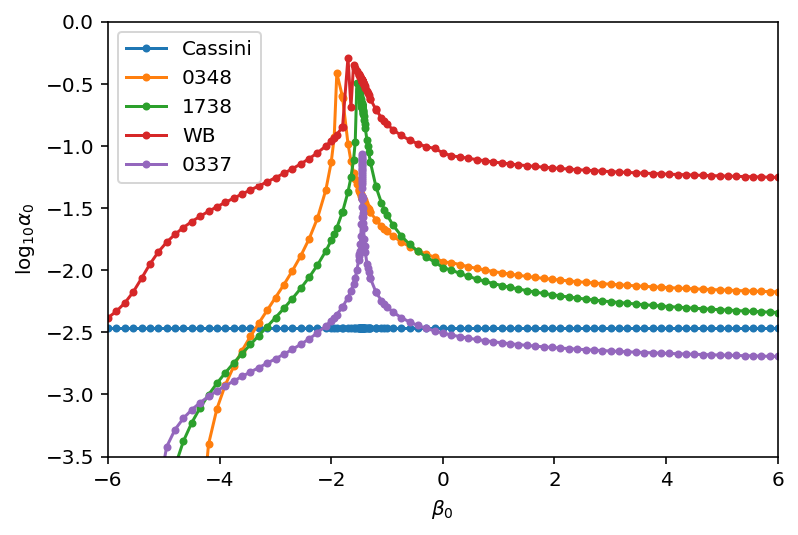

In [84]:
for name, betas, alphas in [
    ("Cassini", betas, alphas_cassini),
    ("0348", betas, alphas_0348),
    ("1738", betas, alphas_1738),
    ("WB", betas, alphas_existing_SEP),
    ("0337", betas, alphas_0337),
    ]:
    plt.plot(betas, np.log10(np.abs(alphas)), ".-", label=name)

plt.xlim(-6,6)
plt.ylim(-3.5,0)
plt.legend(loc="best")
plt.ylabel(r"$\log_{10}\alpha_0$")
plt.xlabel(r"$\beta_0$")
plt.savefig("alpha-beta-prototype.pdf")

In [85]:
d = dict(betas=betas,
         alphas={
             "0348": alphas_0348,
             "1738": alphas_1738,
             "WB": alphas_existing_SEP,
             "Cassini": alphas_cassini,
             "0337": alphas_0337,
         },
         betas_llr = betas_llr,
         alphas_llr = alphas_llr,
         betas_mess = betas_mess,
         alphas_mess = alphas_mess,
        )
with open("alpha-beta.pickle","wb") as f:
    pickle.dump(d,f)

In [67]:
ns_cache = {}
for k, alpha_map in all_map.items():
    for k2, mr_curve in alpha_map.items():
        for k3, d in mr_curve:
            ns_cache[d["initial"]] = d
print(len(ns_cache))
with open("ns_cache.pickle","wb") as f:
    pickle.dump(ns_cache, f)

1704200


## Double checking for $\beta=-6$

In [840]:
#beta = betas[np.argmax(np.abs(alphas_existing_SEP))]
beta = betas[len(betas)//2]
mass = mass_existing_SEP
condition = condition_existing_SEP
beta

0.0050000000000007816

In [848]:
aa = eos_integrate.explore_beta(all_map, [beta], mass, condition)
aa

Exploring for beta=0.005000
1e-06 5.00603909506e-09
1 0.00500605766205
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
10.5556075392 10.5556075392 condition: -0.00337055927367
11.0812802614 11.0812802614 condition: -0.00272569630853
11.0812806684 11.0812806684 condition: -0.00272565445567
11.0812806697 11.0812806697 condition: -0.00272565295734
11.0812806697 11.0812806697 condition: -0.00272565295734
brentq with 11.0812806697 -0.00272565295734 11.0812806697 inf xtol 1e-12
11.0812806697 11.0812806697 condition: -0.00272565295734
returning 11.0812806697 0.0554417002938 -0.00272565295734


array([ 0.0554417])

In [809]:
eos_integrate.explore_alpha(all_map[beta], beta, mass, condition)

1e-06 -1.14575182479e-06
1 -2.28651923859
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.682542655047
0 0 condition: -0.005
1 1 condition: 0.682542655047
0.0483293023857 0.0483293023857 condition: -0.00373879681214
0.515700826872 0.515700826872 condition: -0.00187275478501
0.53040363982 0.53040363982 condition: -6.03865978055e-10
0.530406119414 0.530406119414 condition: 1.45180121541e-06
0.530403639822 0.530403639822 condition: 1.99943983245e-10
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639822 0.530403639822 condition: 1.99943983245e-10
brentq with 0.530403639821 -5.32548956322e-10 0.530403639822 1.99943983245e-10 xtol 1e-12
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639822 0.530403639822 condition: 1.99943983245e-10
returning 0.530403639822 -0.89448640848 1.99943983245e-10


{'Delta': -0.0050000001999439833,
 'I_A': -1.9464990540137698e+37,
 'J_A': -1.9464990038451893e+37,
 'Omega': 0.99999997422624975,
 'Q1': 1.3379600817736124,
 'Q2': 0.89405633953920904,
 'R': 19.616173748146583,
 'a': 0,
 'alpha_0': -0.89448640847951233,
 'alpha_A': -0.8888966083969787,
 'b': -2.5471249999999999,
 'beta_0': -2.5471249999999999,
 'initial': (6.701254825930502e+34, 0.5304036398217481, -2.5471249999999999),
 'm_A': 1.4000000002512825,
 'mb_A': 1.8580771707467361,
 'nu_hat': -0.23585428974780773,
 'nu_prime': 1.3504082034812001e-07,
 'phi_0': 0.35117491622103836,
 'rho_start': 1e-06}

In [849]:
alpha_map = all_map[beta]
for phi_c in np.exp(np.linspace(np.log(11.081), np.log(11.082), 20)):
    eos_integrate.try_alpha(alpha_map, phi_c, beta, mass)

In [850]:
#beta = -6
alpha_map = all_map[beta]
ds = []
for k in sorted(alpha_map.keys()):
    try:
        ds.append(eos_integrate.mr_curve(alpha_map[k], k, beta, mass))
    except eos_integrate.EOSError:
        print(k, "not possible")
phi_c_min = eos_integrate.find_scalarization(alpha_map, beta, mass)
phi_c_min

11.0812806697 not possible
11.0812806699 not possible
11.0812806701 not possible
11.0812806718 not possible
11.0812806752 not possible
11.0812807343 not possible
11.0812816851 not possible
11.0812835918 not possible
11.0812988501 not possible
11.0813157797 not possible
11.0813684106 not possible
11.0814210416 not possible
11.081473673 not possible
11.0815263045 not possible
11.0815429877 not possible
11.0815789364 not possible
11.0816315684 not possible
11.0816842008 not possible
11.0817368334 not possible
11.0817894662 not possible
11.0818420993 not possible
11.0818947326 not possible
11.0819473662 not possible
11.082 not possible
11.0820312679 not possible
11.0859375144 not possible
11.0937500126 not possible
11.1250000104 not possible
11.2500000064 not possible
11.5000000034 not possible
12.0000000025 not possible
16 not possible
1e-06 5.00603909506e-09
1 0.00500605766205
No spontaneous scalarization found


0

(-0.01, 0.01)

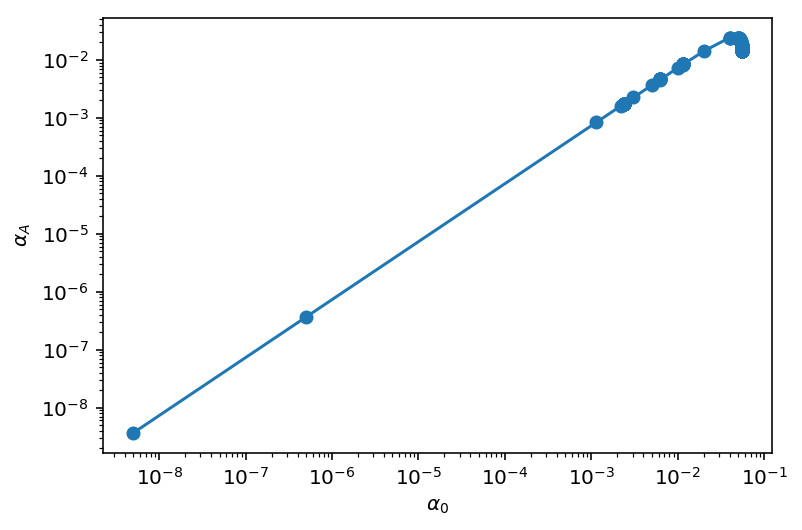

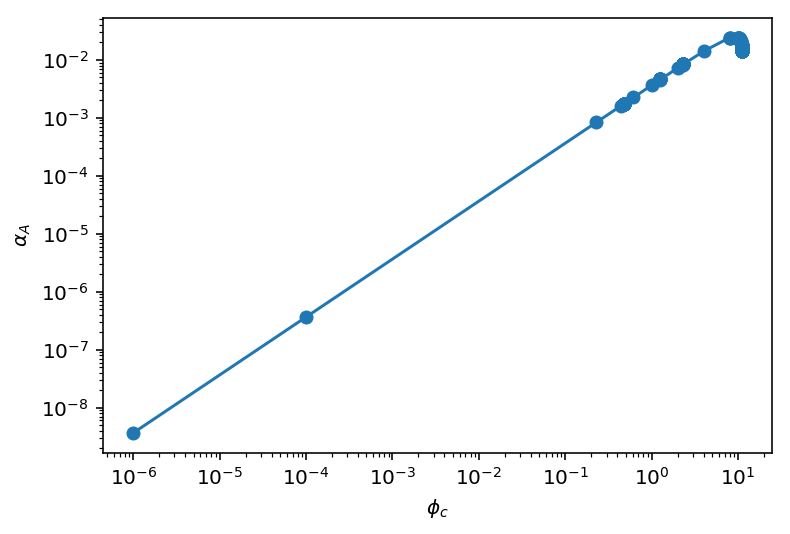

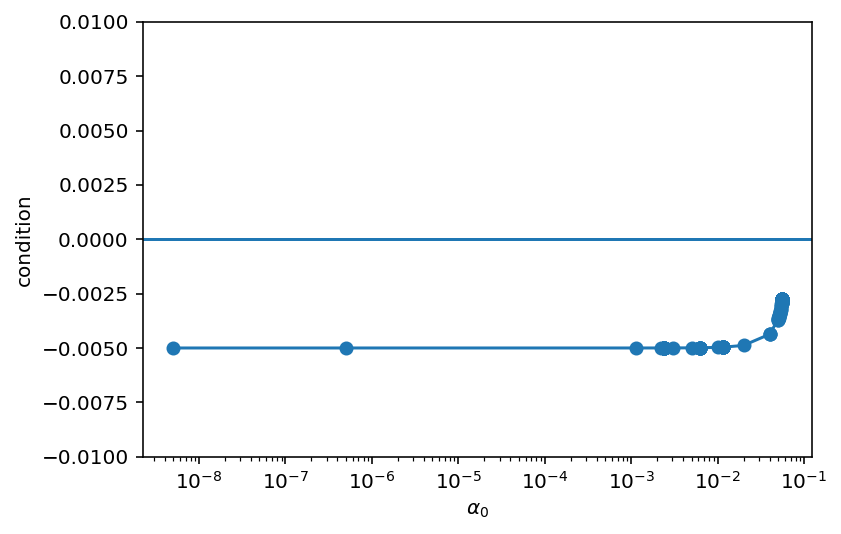

In [851]:
plt.loglog([abs(d["alpha_0"]) for d in ds if d["initial"][1]>phi_c_min],
           [abs(d["alpha_A"]) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
#plt.axhline(1.6e-6)
plt.figure()
plt.loglog([abs(d["initial"][1]-phi_c_min) for d in ds if d["initial"][1]>phi_c_min],
           [abs(d["alpha_A"]) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.xlabel(r"$\phi_c$")
plt.ylabel(r"$\alpha_A$")
#plt.axhline(1.6e-6)
plt.figure()

plt.semilogx([abs(d["alpha_0"]) for d in ds if d["initial"][1]>phi_c_min],
           [condition(d) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.axhline(0)
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"condition")
plt.ylim(-0.01,0.01)

## Checking the constraint behaviour

In [340]:
mass = mass_0348
beta = -5

if beta not in all_map:
    all_map[beta] = {}
alpha_map = all_map[beta]

phis = []
alpha_0s = []
alpha_As = []

for phi_c in sorted(alpha_map):
    print(phi_c)
    d = eos_integrate.mr_curve(alpha_map[phi_c], phi_c, beta, mass) 
    phis.append(phi_c)
    alpha_0s.append(d["alpha_0"])
    alpha_As.append(d["alpha_A"])
    
phis = np.array(phis)
alpha_0s = np.array(alpha_0s)
alpha_As = np.array(alpha_As)

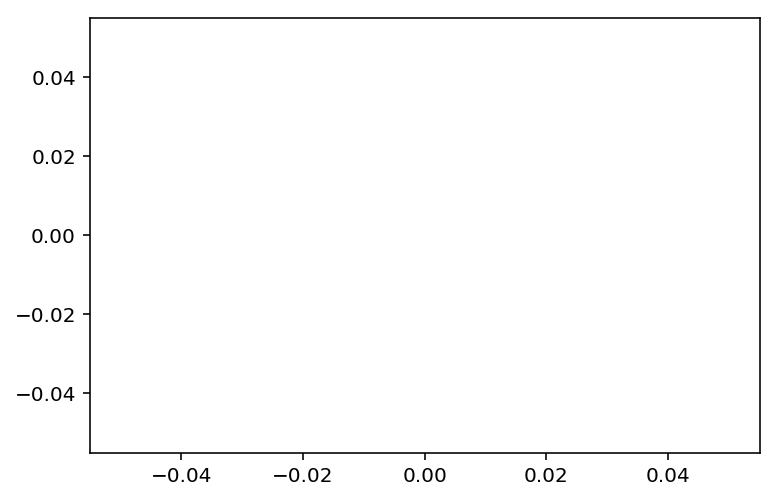

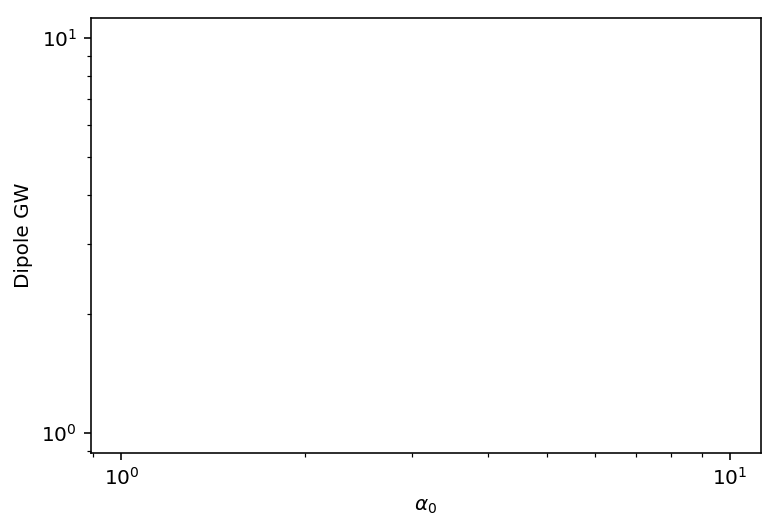

In [341]:
plt.plot(phis, alpha_0s)
plt.plot(phis, alpha_As)
plt.figure()
plt.loglog(alpha_0s, np.abs(alpha_As-alpha_0s))
plt.xlabel(r"$\alpha_0$")
plt.ylabel("Dipole GW")

In [447]:
phi_c = 0.2e-3
beta = -5
mr = []
d = eos_integrate.mr_curve(mr, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(0.00010415328624231039, 0.0004256220413308578)

In [504]:
phi_c = 0.5
beta = -5
mr2 = []
d = eos_integrate.mr_curve(mr2, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(1.2325626474920834, 1.2785514074907005)

In [464]:
phi_c = 8e-2
beta = -1
mr3 = []
d = eos_integrate.mr_curve(mr3, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(0.058344099706410024, 0.044284977965885708)

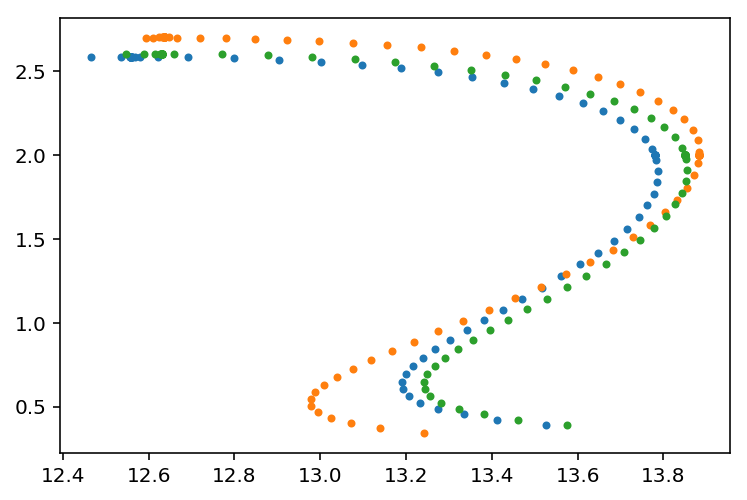

In [465]:
xs = []
ys = []
for pc, d in mr:
    xs.append(d["R"])
    ys.append(d["m_A"])
xs2 = []
ys2 = []
for pc, d in mr2:
    xs2.append(d["R"])
    ys2.append(d["m_A"])
xs3 = []
ys3 = []
for pc, d in mr3:
    xs3.append(d["R"])
    ys3.append(d["m_A"])
plt.plot(xs, ys, ".")
plt.plot(xs2, ys2, ".")
plt.plot(xs3, ys3, ".")


In [367]:
# Figure 4 of 0348 paper
beta = -5

if beta not in all_map:
    all_map[beta] = {}
alpha_map = all_map[beta]

ms = np.linspace(0.4,2.4,10)
alpha_As = []
for m in ms:
    print("Evaluating",m)
    d = eos_integrate.explore_alpha(alpha_map, beta, m, 
                                    lambda d: -d["alpha_0"]-1e-4)
    alpha_As.append(d["alpha_A"])
alpha_As = np.array(alpha_As)

Evaluating 0.4
1.953125e-06 -9.45729679921e-05
Starting search
1.953125e-06 -9.45729679921e-05
Bisection searching
0.000201776697526 0.000460664914505
7.41742480885e-05 0.000106103567507
3.5987023067e-05 -5.00178829103e-09
5.01204304013e-05 3.92666504657e-05
3.59888235082e-05 9.15227434312e-13
bisection found 3.5987023067e-05 3.59888235082e-05
3.59888235082e-05 9.15227434312e-13
Bracketing done 3.5987023067e-05 3.59888235082e-05
3.5987023067e-05 -5.00178829103e-09
3.59888235082e-05 9.15227434312e-13
3.5987023067e-05 -5.00178829103e-09
3.59888235082e-05 9.15227434312e-13
Evaluating 0.622222222222
1.953125e-06 -9.61031361779e-05
Starting search
1.953125e-06 -9.61031361779e-05
Bisection searching
0.000201776697526 0.000302583786848
7.41742480885e-05 4.79920428214e-05
3.5987023067e-05 -2.81988950205e-05
5.01204304013e-05 -1.64853699268e-13
5.01229374228e-05 5.00190440998e-09
bisection found 5.01204304013e-05 5.01229374228e-05
5.01229374228e-05 5.00190440998e-09
Bracketing done 5.0120430401

AlphaProblem: Integration problems prevent condition being met

In [ ]:
plt.plot(ms, alpha_As)

## Spontaneous scalarization, where is it?

In [492]:
phi_c = 1
beta = -5
mr = []
d = eos_integrate.mr_curve(mr, phi_c, beta, mass_0348)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(4.7520576398969165, 4.1006113194158447)

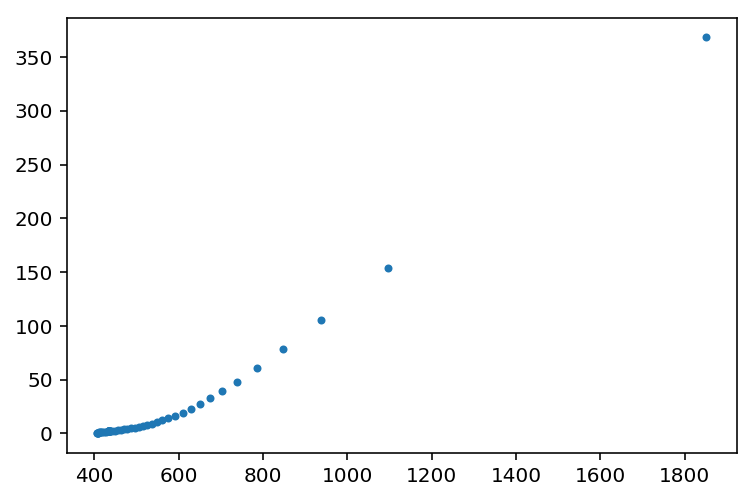

In [493]:
xs = []
ys = []
for pc, d in mr:
    xs.append(d["R"])
    ys.append(d["m_A"])
plt.plot(xs, ys, ".")

In [494]:
p_c, phi_c, beta = d["initial"]
N = eos_integrate.NeutronStar(a=0, b=beta)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
A_phi = np.array([N.A(phii) for phii in phi])
e = np.array([N.energy_density(pi) for pi in p])
a_phi = N.a + N.b*phi

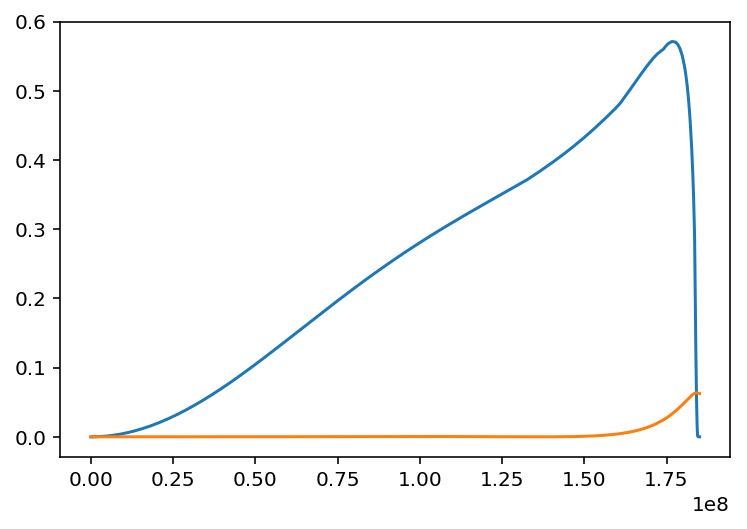

In [495]:
# M_prime terms
plt.plot(rs, (4*np.pi*eos_integrate.G/eos_integrate.c**4*rs**2
              *A_phi**4*e))                                                                    
plt.plot(rs, rs*(rs-2*M)*psi**2/2)


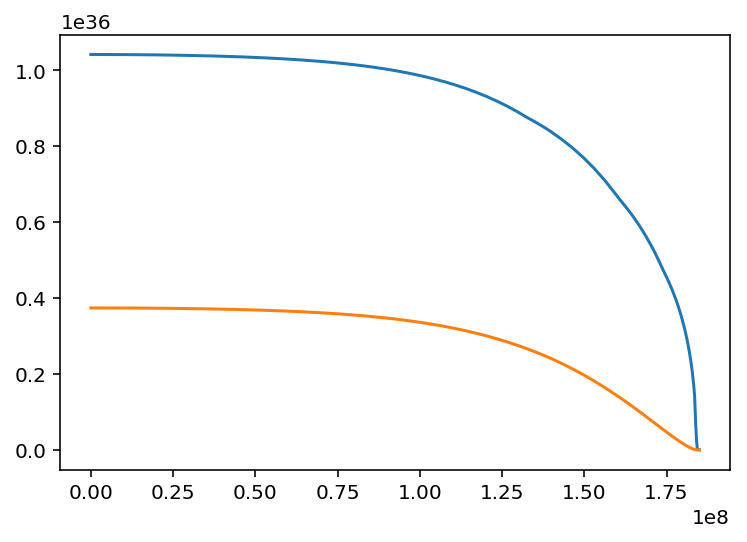

In [496]:
plt.plot(rs, e)
plt.plot(rs, p)

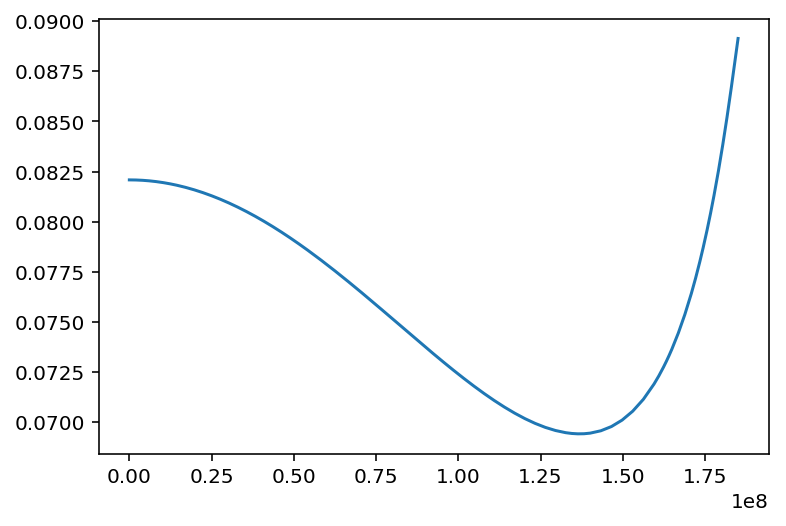

In [497]:
plt.plot(rs, A_phi)

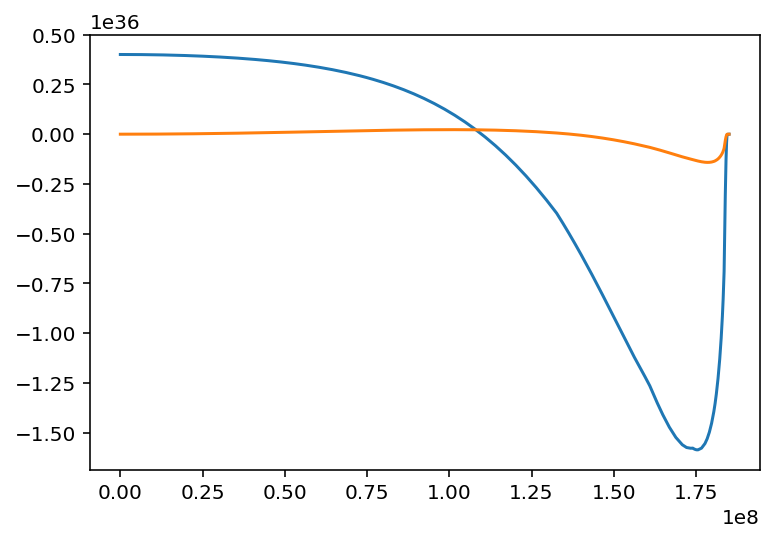

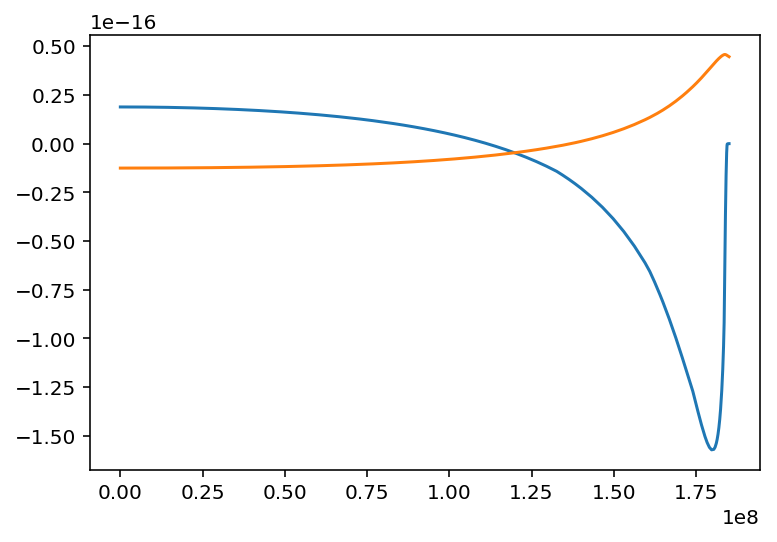

In [498]:
# psi_prime terms
plt.plot(rs, a_phi*(e-3*p))
plt.plot(rs, rs*psi*(e-p))
plt.figure()
plt.plot(rs, 4*np.pi*eos_integrate.G/eos_integrate.c**4
             * rs*A_phi**4/(rs-2*M)
             * (a_phi*(e-3*p)+rs*psi*(e-p)))
plt.plot(rs, - 2*(rs-M)*psi/(rs*(rs-2*M)))

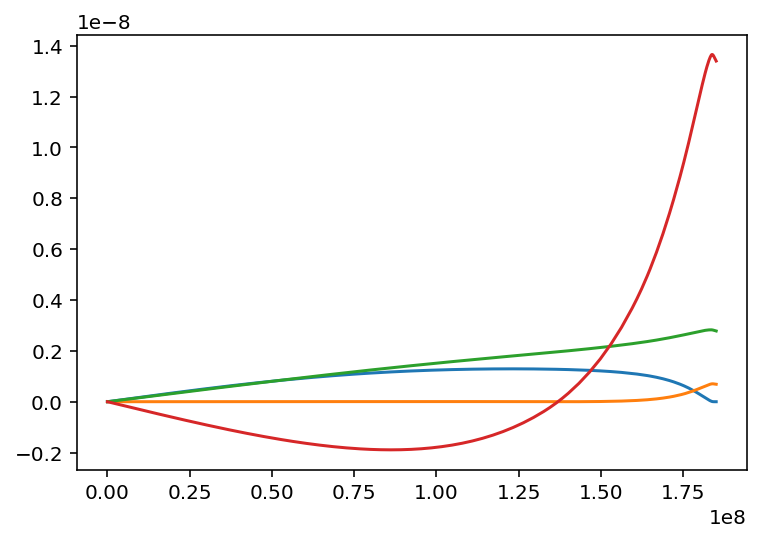

In [499]:
# p terms
plt.plot(rs, 4*np.pi*eos_integrate.G/eos_integrate.c**4
             *rs**2*A_phi**4*p/(rs-2*M))
plt.plot(rs, rs*psi**2/2)
plt.plot(rs, M/(rs*(rs-2*M)))
plt.plot(rs, a_phi*psi)
        

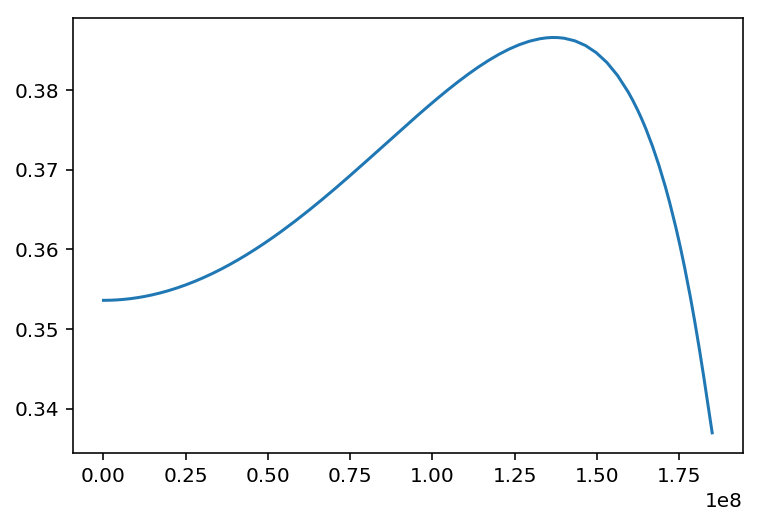

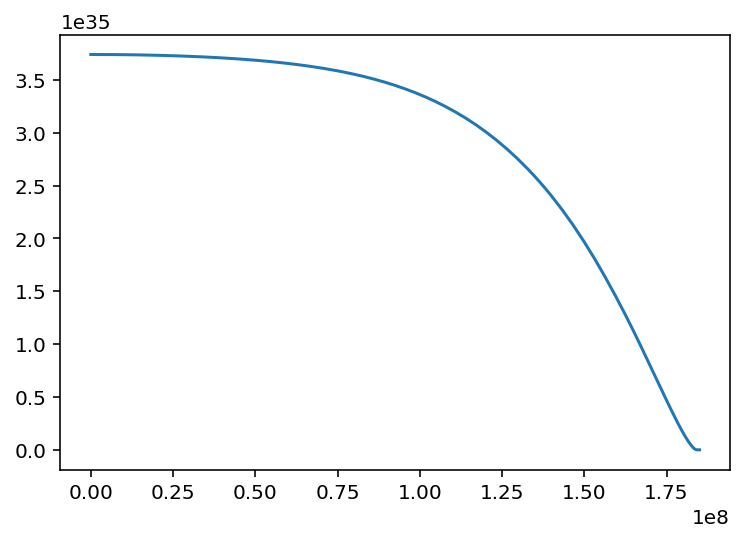

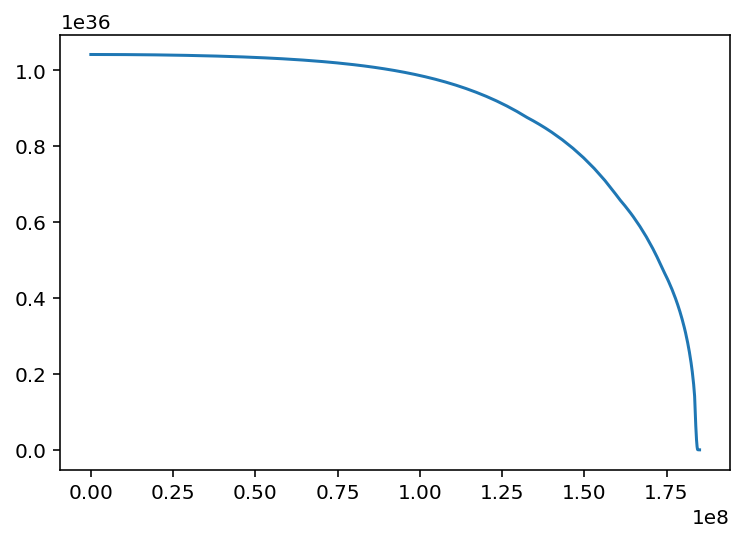

In [500]:
plt.plot(rs, phi-N.phi_0)
plt.figure()
plt.plot(rs, p)
plt.figure()
plt.plot(rs, [N.energy_density(pi) for pi in p])

In [501]:
p_c, phi_c, beta = d["initial"]
N = eos_integrate.NeutronStar(a=0, b=beta)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T

N2 = eos_integrate.NeutronStar(a=0, b=beta)
rs2, xs2 = N2.integrate(p_c = p_c, phi_c = 0.4)
rs2 = np.array(rs2)
xs2 = np.array(xs2)
M2, nu2, phi2, psi2, p2, Mb2, omega2, omicron2 = xs2.T

phi_c

1

-5

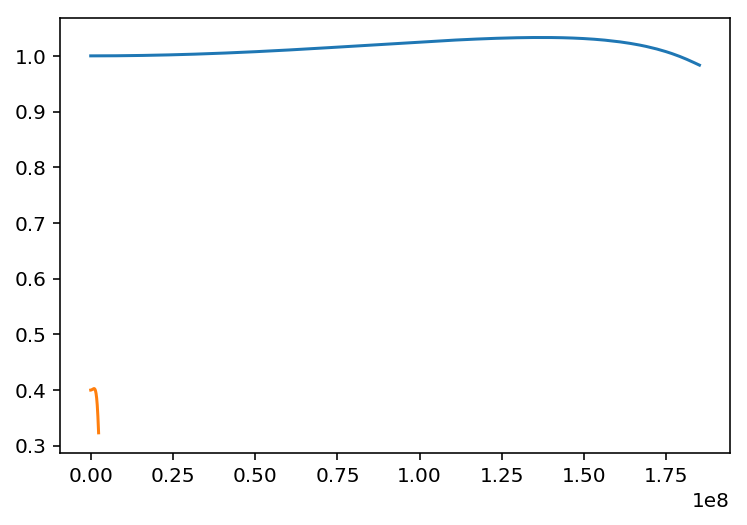

In [502]:
plt.plot(rs, phi)
plt.plot(rs2, phi2)
beta

In [441]:
rs[-1]-rs[-2]

0.0

In [444]:
# Figure 1 of de96
dd = eos_integrate.evaluate(p_c,phi_c,beta)
dd["phi_0"], dd["alpha_0"], dd["alpha_A"]

(-0.0048155617554606345, 0.024077808777303172, -0.10665665069520933)

In [552]:
phi_cs = np.exp(np.linspace(np.log(1e-1),np.log(1),40))
ds = [eos_integrate.mr_curve([],phi_c,-6, mass_0348) 
      for phi_c in phi_cs]

(2, 3)

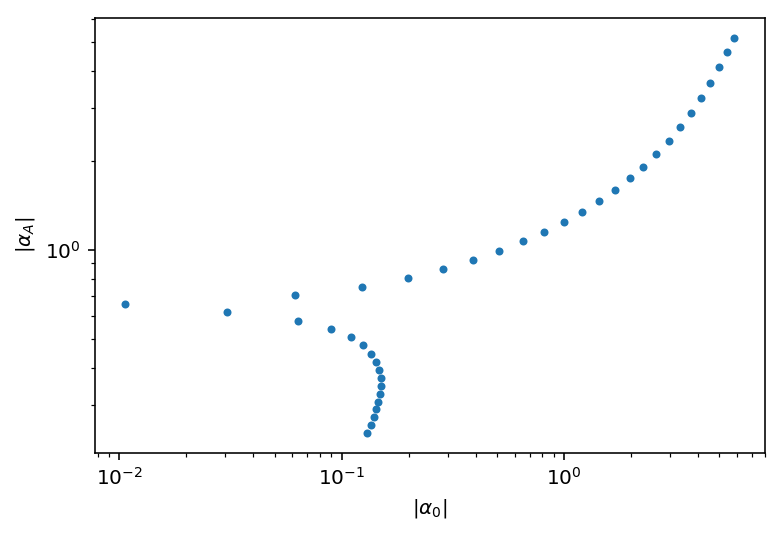

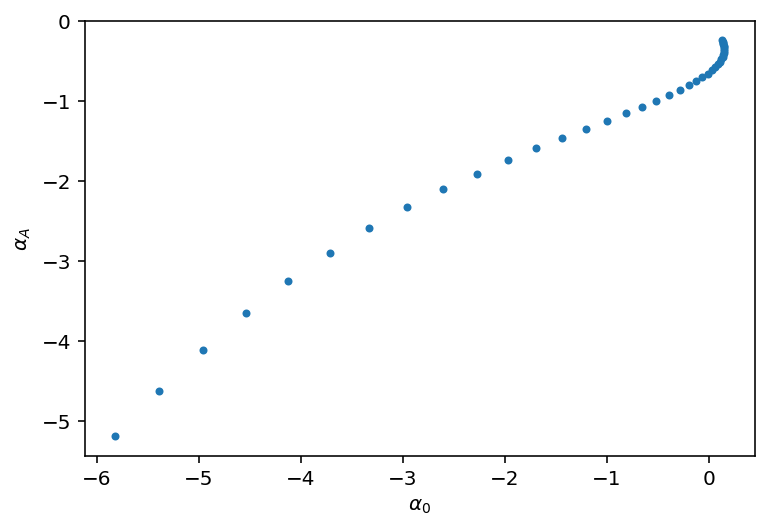

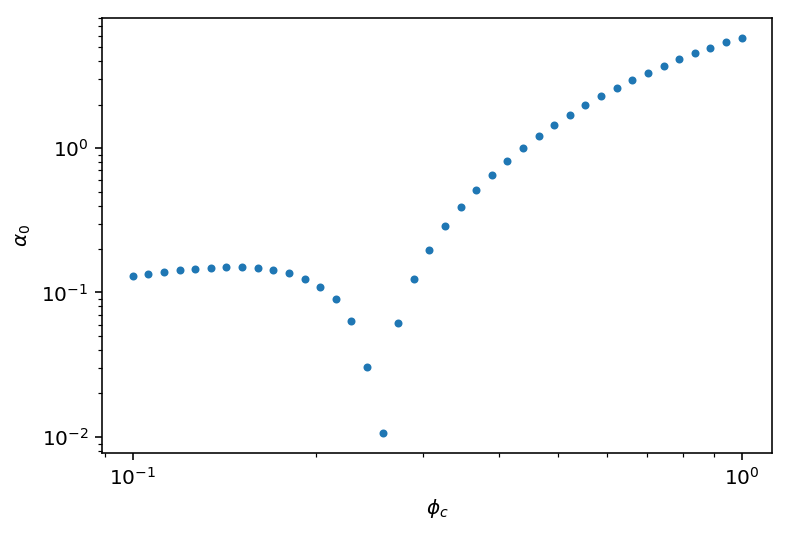

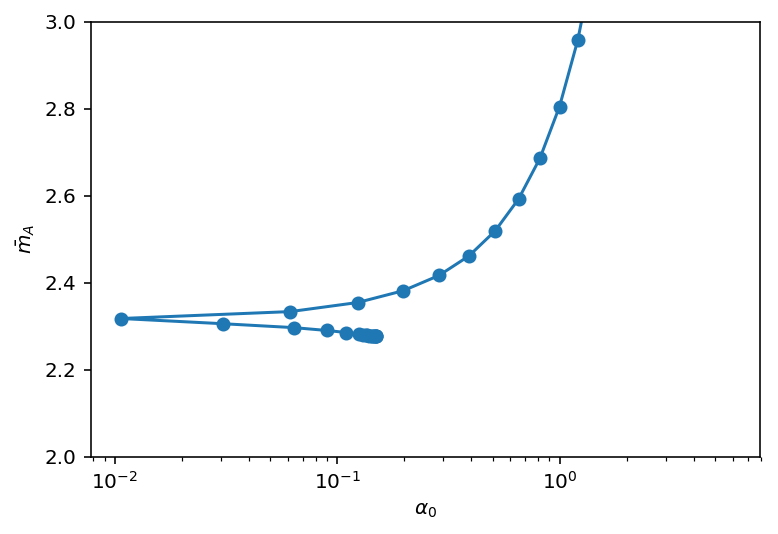

In [554]:
plt.loglog([abs(d["alpha_0"]) for d in ds],
         [abs(d["alpha_A"]) for d in ds], ".")
plt.xlabel(r"$|\alpha_0|$")
plt.ylabel(r"$|\alpha_A|$")
plt.figure()
plt.plot([(d["alpha_0"]) for d in ds],
         [(d["alpha_A"]) for d in ds], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
plt.figure()
plt.loglog(phi_cs,
           [abs(d["alpha_0"]) for d in ds], ".")
plt.xlabel(r"$\phi_c$")
plt.ylabel(r"$\alpha_0$")
plt.figure()
plt.semilogx([abs(d["alpha_0"]) for d in ds],
         [abs(d["mb_A"]) for d in ds], "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\bar m_A$")
plt.ylim(2,3)

In [522]:
pickle.dump?

In [521]:
import pickle

## Exploring where spontaneous scalarization occurs

In [622]:
all_map = {}

In [642]:
beta = -1
mass = mass_0348

if beta not in all_map:
    all_map[beta] = {}
scalar_phi = eos_integrate.find_scalarization(all_map[beta], beta, mass)

0.0001 -7.28637489627e-05
1 -0.852302302118


In [643]:
mass = mass_0337
condition = condition_0337
scalar_phi = eos_integrate.find_scalarization(all_map[beta], beta, mass)
d = eos_integrate.explore_alpha(all_map[beta], beta, mass, condition)
d

0.0001 -7.6515575198e-05
1 -0.880694515618
0.0001 -7.6515575198e-05
1 -0.880694515618
0 condition: -1.6e-06
1 condition: 0.0858074956864
0 condition: -1.6e-06
1 condition: 0.0858074956864
0.0001 condition: -1.59938404927e-06
0.0001 condition: -1.59938404927e-06
1 condition: 0.0858074956864
brentq with 0.0001 -1.59938404927e-06 1 0.0858074956864
0.0001 condition: -1.59938404927e-06
1.0 condition: 0.0858074956864
0.00011863700007 condition: -1.5991330655e-06
0.118861325273 condition: 0.000873957138593
0.000335510963802 condition: -1.5930663895e-06
0.0571814664625 condition: 0.000200080460905
0.000784550469875 condition: -1.56208702574e-06
0.0232512762883 condition: 3.17074215119e-05
0.00183941970163 condition: -1.39159493558e-06
0.0100875035443 condition: 4.66804999428e-06
0.00373358872252 condition: -7.41378818088e-07
0.00559732844395 condition: 3.29805110985e-07
0.00502350459448 condition: -4.55944146317e-08
0.00509319877556 condition: -2.16435968394e-09
0.0050966493771 condition: 1.43

{'Delta': -1.6000014313110808e-06,
 'I_A': 5.5548773491536225e+37,
 'J_A': 5.554877433041515e+37,
 'Omega': 1.0000000151016641,
 'Q1': 1.0000060881758677,
 'Q2': 0.83036484641709329,
 'R': 13.657143568676775,
 'a': 0,
 'alpha_0': -0.0038997512184057418,
 'alpha_A': -0.0034894682691346398,
 'b': -1,
 'beta_0': -1,
 'initial': (6.269867580732077e+34, 0.005096649377103543, -1),
 'm_A': 1.4378000000507549,
 'mb_A': 1.5757733448171813,
 'nu_hat': -0.37178067969001799,
 'nu_prime': 3.2972838316543817e-07,
 'phi_0': 0.0038997512184057418,
 'rho_start': 1e-06}

In [644]:
alpha_map = all_map[beta]
ds = []
for phi_c in sorted(alpha_map.keys()):
    try:
        ds.append(eos_integrate.mr_curve(alpha_map[phi_c], phi_c, beta, mass))
    except eos_integrate.EOSError:
        pass

-1

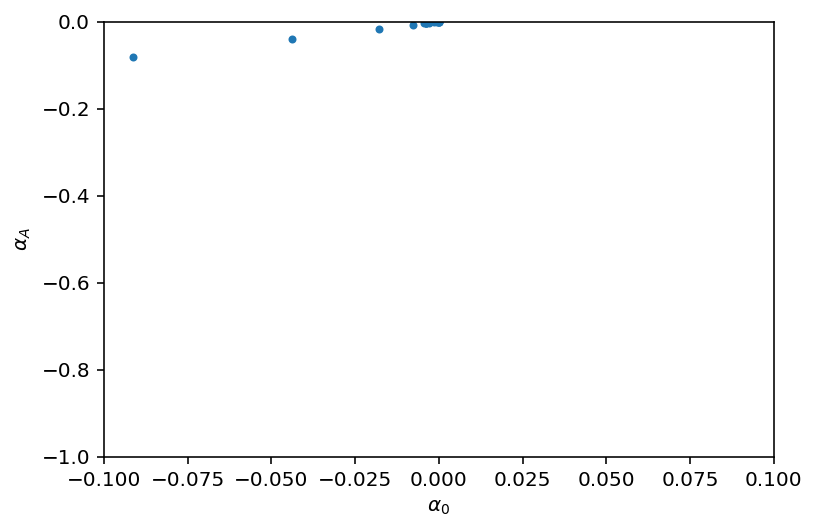

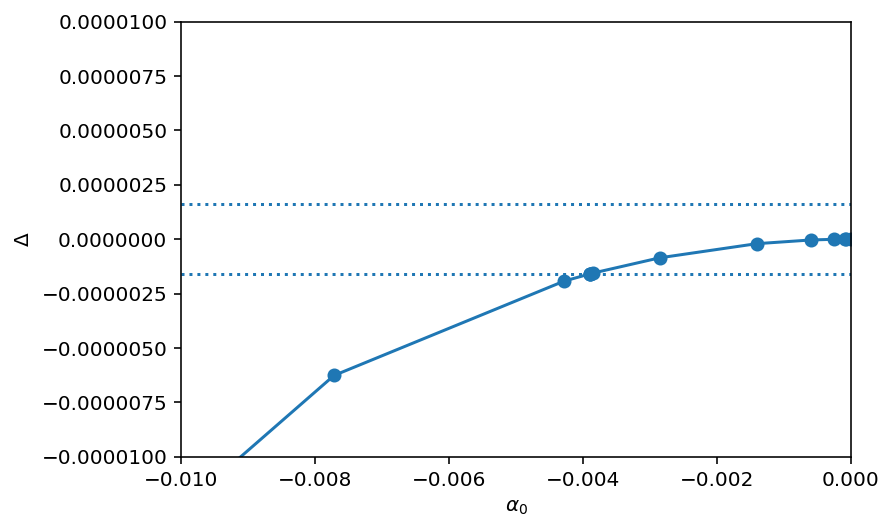

In [649]:
plt.plot([(d["alpha_0"]) for d in ds if d["initial"][1]>=scalar_phi],
         [(d["alpha_A"]) for d in ds if d["initial"][1]>=scalar_phi], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
plt.xlim(-0.1,0.1)
plt.ylim(-1,0)
plt.figure()
plt.plot([(d["alpha_0"]) for d in ds if d["initial"][1]>=scalar_phi],
         [(d["Delta"]) for d in ds if d["initial"][1]>=scalar_phi], 
         "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\Delta$")
plt.axhline(1.6e-6,linestyle=":")
plt.axhline(-1.6e-6,linestyle=":")
plt.ylim(-1e-5,1e-5)
plt.xlim(-1e-2,0)
beta

In [646]:
beta

-1

In [647]:
scalar_phi

0

In [648]:
d

{'Delta': -0.085809095686351242,
 'I_A': -1.1034227274560479e+40,
 'J_A': -1.103422583827089e+40,
 'Omega': 0.99999986983324218,
 'Q1': 1.2702353772323556,
 'Q2': 0.92218447183186658,
 'R': 27.625395447972895,
 'a': 0,
 'alpha_0': -0.88069451561757184,
 'alpha_A': -0.78326107625275521,
 'b': -1,
 'beta_0': -1,
 'initial': (3.4527346740628564e+34, 1, -1),
 'm_A': 1.4377999999539155,
 'mb_A': 2.2897787643016803,
 'nu_hat': -0.16651543307788805,
 'nu_prime': 6.5484338332231337e-08,
 'phi_0': 0.88069451561757184,
 'rho_start': 1e-06}